We download what we need from Dropbox: the folder with the **datasets** and the **utils** folder, finally we download the `nflows` package.

In [14]:
!mkdir utils
!mkdir data
!mkdir modelli
!mkdir figures
!wget --output-document=./utils/model.py https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f&dl=0
!wget --output-document=./utils/our_classes.py https://www.dropbox.com/scl/fi/w8sth2i67t26agcvk8nxt/our_classes.py?rlkey=zdl86xxnogw50didjh7b3isix&dl=0
!wget --output-document=./data/dataset_piccolo.txt https://www.dropbox.com/scl/fi/1m1o6kdbeyd6sid8yuw8q/dataset_piccolo.txt?rlkey=hl8xvtrqj3mch3kjzjegw3wns&dl=0
!wget --output-document=./data/dataset.txt https://www.dropbox.com/scl/fi/wsw8e5uitd50tbjactzl3/dataset.txt?rlkey=arv1nh6dpwg1ipmehf5cvx9y5&dl=0
!wget --output-document=./data/test_dataset.txt https://www.dropbox.com/scl/fi/jhkucfrge74eu65bf5iqy/test_dataset.txt?rlkey=wjgg3rd72t3u47rr0ex8tbwj6&dl=0
!wget --output-document=./modelli/epoch=999modello-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth https://www.dropbox.com/scl/fi/nm60qg2odrqnnleu39vtr/epoch-999modello-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth?rlkey=awyanm6zemgjj2h8ch3h01m8u&dl=0

!pip install nflows

mkdir: cannot create directory ‘utils’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘modelli’: File exists
mkdir: cannot create directory ‘figures’: File exists
--2024-02-26 18:26:56--  https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc30255305a069ca0b951359b537.dl.dropboxusercontent.com/cd/0/inline/COCy5xJunNxAtz5vsI0wOqmL9TAA1gN1q5c8oLukaDG24FR9_TimvklhV3lM_Uv-vLZGJ58aBDNxuuoHghzlgq39sc0L4rTMvAQX0_pjG5Bpz3aAn1Sk43MSLAPMhUIMDUUCp-TwylqSNAWyJNgXp3Hh/file# [following]
--2024-02-26 18:26:57--  https://uc30255305a069ca0b951359b537.dl.dropboxusercontent.com/cd/0/inline/COCy5xJunNxAtz5vsI0wOqmL9TAA1gN1q5c8oLukaDG24FR9_TimvklhV3lM_Uv-vLZGJ58aBDNxuuoHghzlgq39sc0L4

In [3]:
import torch
from tqdm import tqdm

from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import stat
import time

The original data has 24 features, we created a dictionary to contain the names and units of measurement.

In [4]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

Import of *training*, *validation* and *test* datasets. For simplicity and to make calculations faster we have limited ourselves to the first four features. We also limited ourselves on the number of events, mainly to avoid running out of GPU memory.<br>
The number of events considered before and after the reduction is printed, together with an example event, the 100th.

In [5]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest_all = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}\n'.format(L))

x = x[:int(L/2),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest_all = xtest_all[:,0:num_features]

print('Events = {}\n'.format(len(x)))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

Number of events in all the training dataset = 472827

Events = 236413

attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



Here a preprocessing procedure is applied to the input data, using the `forward` method of the `Preprocessor` class defined by us.<br>
We apply the logarithm on $p_T$ and on $mass$, after shifting the data to ensure that they were far from divergence. Then we bring all data to zero mean and unit variance with `StandardScaler`. Finally we apply the `QuantileTransformer` to bring $\eta$ and $\phi$ into a normal distribution, this last transformation is particularly suitable for training of angular distributions. The `preprocessor_settings` dictionary is created to contain this information.

We define a preprocessor for both the training and validation data, so we will do the inverse transformation by calling the `backward` method.<br>
The preprocessed data is brought to the GPU, where the flow works.

In [6]:
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([1,2]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Below we report the plot for the distributions of the original and preprocessed data.

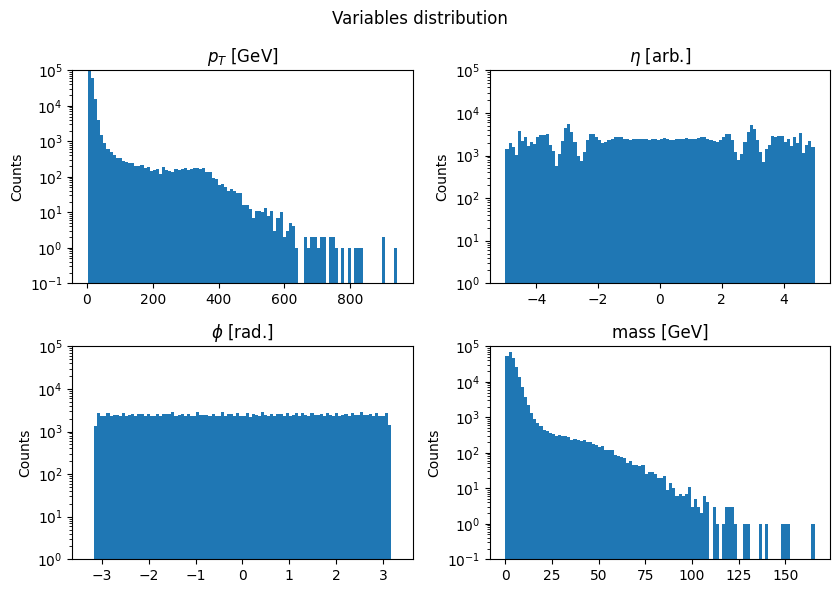

In [7]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1e-1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

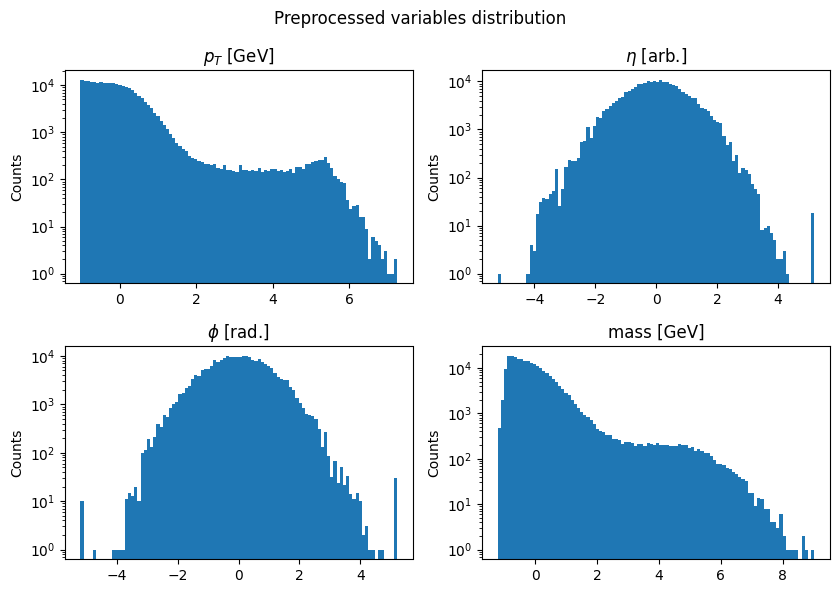

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)

Before actually training the model, we tried to understand which parameters are best. The flow is trained for a different number of transformations, giving the neural network that will be created an increasing number of hidden_features. <br>
We choose to train for 100 epochs, although they are not many they are sufficient to allow a comparison between the various models. See the plot below, where the validation loss is shown in dashed lines.


In [ ]:
###Model Optimization
range_iterations = ([2, 4, 6, 8])
range_hidden_features = ([16, 32, 64, 128])

epochs = 30
batch_size = 1024
val_batch_size = 10000

loss_storer = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))
loss_storer_val = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))

for j in range(len(range_iterations)):
  it = range_iterations[j]
  for k in range(len(range_hidden_features)):
    hf = range_hidden_features[k]
    flow_opt, optimizer_opt, scheduler_opt= model_definer(num_features=num_features, num_iterations=it, hidden_features=hf, patience = 2, factor = 0.5, min_lr = 1e-6, initial_lr = 1e-2)
    start_i = time.time()

    for i in range(epochs):
      epoch_loss = 0
      for jj in tqdm(range(0,len(xt),batch_size)):
        x_batch = xt[jj:jj+batch_size]
        optimizer_opt.zero_grad()
        loss_opt = -flow_opt.log_prob(inputs=x_batch).mean()
        loss_opt.backward()
        optimizer_opt.step()
        epoch_loss += loss_opt.cpu().detach()
      scheduler_opt.step(metrics=epoch_loss)
      epoch_loss /= (len(xt)//batch_size)
      loss_storer[j,k,i] = epoch_loss

      with torch.no_grad():
        epoch_val_loss = 0
        for kk in range(0, len(xval),val_batch_size):
          xval_batch = xval[kk:kk+val_batch_size]
          loss_opt_val = -flow_opt.log_prob(inputs=xval_batch).mean().cpu()
          epoch_val_loss += loss_opt_val
        epoch_val_loss /= (len(xval)//val_batch_size)
        loss_storer_val[j,k,i] = epoch_val_loss
    end_i = time.time()
    print('Time = {:0.05} s\n'.format(end_i-start_i))

Num. iterations = 2, Num. hidden_features = 16, Num. trainable parameters = 2608


100%|██████████| 231/231 [00:01<00:00, 197.42it/s]


Time = 44.125 s

Num. iterations = 2, Num. hidden_features = 32, Num. trainable parameters = 9296


100%|██████████| 231/231 [00:01<00:00, 197.98it/s]


Time = 40.55 s

Num. iterations = 2, Num. hidden_features = 64, Num. trainable parameters = 34960


100%|██████████| 231/231 [00:01<00:00, 193.62it/s]


Time = 42.645 s

Num. iterations = 2, Num. hidden_features = 128, Num. trainable parameters = 135440


100%|██████████| 231/231 [00:01<00:00, 191.70it/s]


Time = 42.124 s

Num. iterations = 4, Num. hidden_features = 16, Num. trainable parameters = 5216


100%|██████████| 231/231 [00:02<00:00, 108.83it/s]


Time = 73.047 s

Num. iterations = 4, Num. hidden_features = 32, Num. trainable parameters = 18592


100%|██████████| 231/231 [00:02<00:00, 110.55it/s]


Time = 72.279 s

Num. iterations = 4, Num. hidden_features = 64, Num. trainable parameters = 69920


100%|██████████| 231/231 [00:02<00:00, 83.56it/s]


Time = 77.893 s

Num. iterations = 4, Num. hidden_features = 128, Num. trainable parameters = 270880


100%|██████████| 231/231 [00:02<00:00, 106.18it/s]


Time = 77.06 s

Num. iterations = 6, Num. hidden_features = 16, Num. trainable parameters = 7824


100%|██████████| 231/231 [00:03<00:00, 76.08it/s]


Time = 104.41 s

Num. iterations = 6, Num. hidden_features = 32, Num. trainable parameters = 27888


100%|██████████| 231/231 [00:03<00:00, 61.22it/s]


Time = 105.85 s

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


100%|██████████| 231/231 [00:03<00:00, 75.78it/s]


Time = 106.27 s

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


100%|██████████| 231/231 [00:04<00:00, 54.04it/s]


Time = 110.41 s

Num. iterations = 8, Num. hidden_features = 16, Num. trainable parameters = 10432


100%|██████████| 231/231 [00:04<00:00, 55.27it/s]


Time = 137.87 s

Num. iterations = 8, Num. hidden_features = 32, Num. trainable parameters = 37184


100%|██████████| 231/231 [00:03<00:00, 58.52it/s]


Time = 144.77 s

Num. iterations = 8, Num. hidden_features = 64, Num. trainable parameters = 139840


100%|██████████| 231/231 [00:03<00:00, 58.53it/s]


Time = 148.35 s

Num. iterations = 8, Num. hidden_features = 128, Num. trainable parameters = 541760


100%|██████████| 231/231 [00:04<00:00, 52.78it/s]


Time = 153.2 s



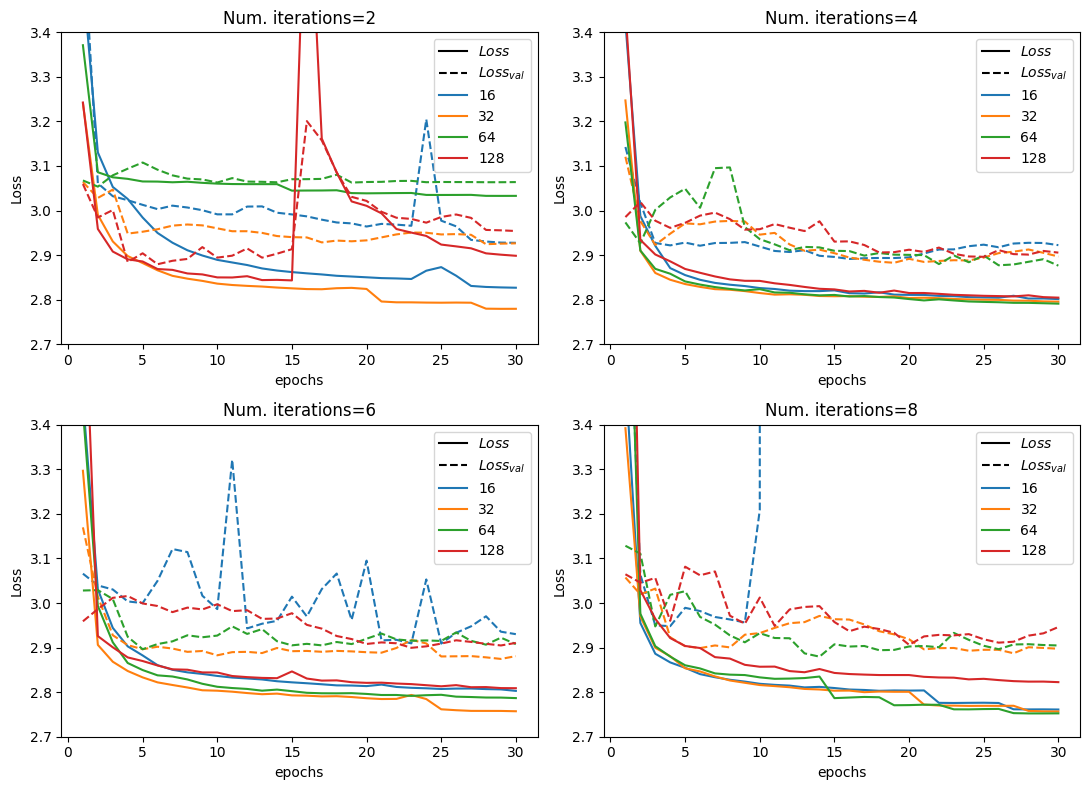

In [ ]:
figlosses, axs = plt.subplots(2, 2, figsize=(11, 8))
colors = cm.tab10(np.linspace(0, 1, 10))

for j in range(len(range_iterations)):
  if j<2: axs[0][j].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[0][j].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  else: axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  for h in range(len(range_hidden_features)):
    if j <2:
      axs[0][j].set_title('Num. iterations={}'.format(range_iterations[j]))
      axs[0][j].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
      axs[0][j].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
      axs[0][j].set_xlabel('epochs')
      axs[0][j].set_ylabel("Loss")
      axs[0][j].legend()
    else:
       axs[1][j-2].set_title('Num. iterations={}'.format(range_iterations[j]))
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
       axs[1][j-2].set_xlabel('epochs')
       axs[1][j-2].set_ylabel("Loss")
       axs[1][j-2].legend()
axs[0][0].set_ylim(top=3.4, bottom=2.7)
axs[0][1].set_ylim(top=3.4, bottom=2.7)
axs[1][0].set_ylim(top=3.4, bottom=2.7)
axs[1][1].set_ylim(top=3.4, bottom=2.7)
figlosses.tight_layout()
plt.show()
figlosses.savefig('figures/Model_optimization.pdf', dpi=190)

Now we deal with the actual training, the parameters chosen for the model are shown below. Note that although a few hundred epochs are enough for the loss to stabilize, they are not enough to allow the model to learn the extremely sharp distributions of $p_T$ and $mass$, which is why it is fixed `epochs = 2000`.





In [11]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


In [12]:
epochs = 1000
batch_size = 10000
val_batch_size = 10000
delta = 3

counter = 0
loss_values = []
best_val_loss = 10000
loss_validation = []
start = time.time()
for i in range(epochs):
  epoch_loss = 0
  for j in tqdm(range(0,len(xt),batch_size)):
    x_batch = xt[j:j+batch_size]
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_batch).mean()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().detach()

  for param_group in optimizer.param_groups:
    lr = param_group['lr']
  epoch_loss /= (len(xt)//batch_size)
  scheduler.step(metrics=epoch_loss)
  loss_values.append(epoch_loss)

  with torch.no_grad():
    val_loss = 0
    for k in range(0, len(xval),val_batch_size):
      x_batch = xval[j:j+val_batch_size]
      loss_val = -flow.log_prob(inputs=xval).mean().cpu()
      val_loss += loss_val
    val_loss /= (len(xval)//val_batch_size)
    loss_validation.append(val_loss)
    if abs(val_loss-epoch_loss) > delta:
      counter += 1
      print('counter=',counter)
      if counter > 10:
        print('Early stopped')
        break
    print('Epoch: {}, Training loss = {}, Validation loss = {}, Learning rate = {}'.format(i,epoch_loss,val_loss,lr))
  if (i+1) % 100 == 0:
    nome='epoch='+str(i)+'modello-N_iter'+str(num_iterations)+'-N_features'+str(hidden_features)+'-N_BS'+str(batch_size)+'-epochs'+str(epochs)+'-lr'+str(initial_lr)+'.pth'
    torch.save(flow.state_dict(), 'modelli/'+nome)
    print('Model saved')


end = time.time()
print('Time = {:0.05} s'.format(end-start))

100%|██████████| 24/24 [00:00<00:00, 71.00it/s]


counter= 1
Epoch: 0, Training loss = 9.314606666564941, Validation loss = 5.809045314788818, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 1, Training loss = 4.424523830413818, Validation loss = 3.5120737552642822, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.34it/s]


Epoch: 2, Training loss = 3.555299758911133, Validation loss = 3.2625784873962402, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.12it/s]


Epoch: 3, Training loss = 3.3690712451934814, Validation loss = 3.146376132965088, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.29it/s]


Epoch: 4, Training loss = 3.2825417518615723, Validation loss = 3.102571964263916, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.93it/s]


Epoch: 5, Training loss = 3.2249815464019775, Validation loss = 3.0621254444122314, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.49it/s]


Epoch: 6, Training loss = 3.189393997192383, Validation loss = 3.046543598175049, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.26it/s]


Epoch: 7, Training loss = 3.160813808441162, Validation loss = 3.022883653640747, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.75it/s]


Epoch: 8, Training loss = 3.138360023498535, Validation loss = 3.0014967918395996, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.17it/s]


Epoch: 9, Training loss = 3.1165924072265625, Validation loss = 2.9853949546813965, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.71it/s]


Epoch: 10, Training loss = 3.0904793739318848, Validation loss = 2.989912986755371, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.57it/s]


Epoch: 11, Training loss = 3.0908069610595703, Validation loss = 2.9616639614105225, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.75it/s]


Epoch: 12, Training loss = 3.062983274459839, Validation loss = 2.959825038909912, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.02it/s]


Epoch: 13, Training loss = 3.0511093139648438, Validation loss = 2.9526283740997314, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.31it/s]


Epoch: 14, Training loss = 3.0422277450561523, Validation loss = 2.946978807449341, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.79it/s]


Epoch: 15, Training loss = 3.0347962379455566, Validation loss = 2.942087173461914, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.15it/s]


Epoch: 16, Training loss = 3.0265729427337646, Validation loss = 2.935295820236206, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.82it/s]


Epoch: 17, Training loss = 3.0167763233184814, Validation loss = 2.9313743114471436, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.60it/s]


Epoch: 18, Training loss = 3.010453224182129, Validation loss = 2.9269332885742188, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 19, Training loss = 3.003945827484131, Validation loss = 2.9222354888916016, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.19it/s]


Epoch: 20, Training loss = 2.994508743286133, Validation loss = 2.9194259643554688, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.25it/s]


Epoch: 21, Training loss = 2.9804840087890625, Validation loss = 2.9405713081359863, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.21it/s]


Epoch: 22, Training loss = 2.968712091445923, Validation loss = 2.905566453933716, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.28it/s]


Epoch: 23, Training loss = 2.957820177078247, Validation loss = 2.903527021408081, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.33it/s]


Epoch: 24, Training loss = 2.9618430137634277, Validation loss = 2.9171478748321533, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 30.62it/s]


Epoch: 25, Training loss = 2.9473462104797363, Validation loss = 2.9062349796295166, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.51it/s]


Epoch: 26, Training loss = 2.9525747299194336, Validation loss = 2.920121192932129, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.26it/s]


Epoch: 27, Training loss = 2.9401862621307373, Validation loss = 2.906827449798584, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.64it/s]


Epoch: 28, Training loss = 2.9419565200805664, Validation loss = 2.9173989295959473, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.42it/s]


Epoch: 29, Training loss = 2.935115098953247, Validation loss = 2.9108545780181885, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.27it/s]


Epoch: 30, Training loss = 2.9352948665618896, Validation loss = 2.914930582046509, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.60it/s]


Epoch: 31, Training loss = 2.9304981231689453, Validation loss = 2.9128899574279785, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.55it/s]


Epoch: 32, Training loss = 2.93017315864563, Validation loss = 2.9146087169647217, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.72it/s]


Epoch: 33, Training loss = 2.9263803958892822, Validation loss = 2.912484645843506, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.64it/s]


Epoch: 34, Training loss = 2.9254751205444336, Validation loss = 2.913419246673584, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 65.87it/s]


Epoch: 35, Training loss = 2.92268967628479, Validation loss = 2.911961793899536, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.21it/s]


Epoch: 36, Training loss = 2.9219858646392822, Validation loss = 2.912890672683716, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.83it/s]


Epoch: 37, Training loss = 2.9194962978363037, Validation loss = 2.911599636077881, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.18it/s]


Epoch: 38, Training loss = 2.9185409545898438, Validation loss = 2.9125194549560547, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.68it/s]


Epoch: 39, Training loss = 2.916297197341919, Validation loss = 2.9099833965301514, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.32it/s]


Epoch: 40, Training loss = 2.9152557849884033, Validation loss = 2.9101717472076416, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.32it/s]


Epoch: 41, Training loss = 2.9133384227752686, Validation loss = 2.9092795848846436, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.75it/s]


Epoch: 42, Training loss = 2.9120006561279297, Validation loss = 2.908416509628296, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.37it/s]


Epoch: 43, Training loss = 2.9106757640838623, Validation loss = 2.9074764251708984, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.27it/s]


Epoch: 44, Training loss = 2.9091684818267822, Validation loss = 2.9075427055358887, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.03it/s]


Epoch: 45, Training loss = 2.9079320430755615, Validation loss = 2.907365560531616, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.56it/s]


Epoch: 46, Training loss = 2.9068503379821777, Validation loss = 2.9062509536743164, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.90it/s]


Epoch: 47, Training loss = 2.905458927154541, Validation loss = 2.9048876762390137, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.74it/s]


Epoch: 48, Training loss = 2.9044089317321777, Validation loss = 2.9044995307922363, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.37it/s]


Epoch: 49, Training loss = 2.9032347202301025, Validation loss = 2.903702735900879, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 31.07it/s]


Epoch: 50, Training loss = 2.9020328521728516, Validation loss = 2.9037625789642334, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.45it/s]


Epoch: 51, Training loss = 2.9010982513427734, Validation loss = 2.9032795429229736, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.54it/s]


Epoch: 52, Training loss = 2.9000813961029053, Validation loss = 2.9040842056274414, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.39it/s]


Epoch: 53, Training loss = 2.899630069732666, Validation loss = 2.904527425765991, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.22it/s]


Epoch: 54, Training loss = 2.898912191390991, Validation loss = 2.9038705825805664, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 58.33it/s]


Epoch: 55, Training loss = 2.8980510234832764, Validation loss = 2.9031527042388916, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.09it/s]


Epoch: 56, Training loss = 2.8975412845611572, Validation loss = 2.9033756256103516, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.10it/s]


Epoch: 57, Training loss = 2.8969852924346924, Validation loss = 2.902921199798584, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.15it/s]


Epoch: 58, Training loss = 2.89639949798584, Validation loss = 2.9032959938049316, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.97it/s]


Epoch: 59, Training loss = 2.8958959579467773, Validation loss = 2.903313398361206, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.02it/s]


Epoch: 60, Training loss = 2.8954176902770996, Validation loss = 2.903745651245117, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 66.31it/s]


Epoch: 61, Training loss = 2.8949222564697266, Validation loss = 2.9042916297912598, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.68it/s]


Epoch: 62, Training loss = 2.894365072250366, Validation loss = 2.9031646251678467, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.62it/s]


Epoch: 63, Training loss = 2.8938496112823486, Validation loss = 2.903093099594116, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.70it/s]


Epoch: 64, Training loss = 2.8934078216552734, Validation loss = 2.9030182361602783, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.41it/s]


Epoch: 65, Training loss = 2.8929970264434814, Validation loss = 2.902505397796631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.47it/s]


Epoch: 66, Training loss = 2.8925111293792725, Validation loss = 2.9028422832489014, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.31it/s]


Epoch: 67, Training loss = 2.8923516273498535, Validation loss = 2.902571678161621, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.97it/s]


Epoch: 68, Training loss = 2.8918395042419434, Validation loss = 2.9030141830444336, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.90it/s]


Epoch: 69, Training loss = 2.8916213512420654, Validation loss = 2.9032535552978516, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.80it/s]


Epoch: 70, Training loss = 2.8915157318115234, Validation loss = 2.9042155742645264, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.40it/s]


Epoch: 71, Training loss = 2.891972780227661, Validation loss = 2.904474973678589, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.54it/s]


Epoch: 72, Training loss = 2.893205404281616, Validation loss = 2.905888795852661, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.12it/s]


Epoch: 73, Training loss = 2.9004154205322266, Validation loss = 2.898228883743286, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.55it/s]


Epoch: 74, Training loss = 2.90816330909729, Validation loss = 2.9589641094207764, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.23it/s]


Epoch: 75, Training loss = 2.8872454166412354, Validation loss = 2.918471336364746, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.91it/s]


Epoch: 76, Training loss = 2.8891897201538086, Validation loss = 2.9439449310302734, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.15it/s]


Epoch: 77, Training loss = 2.8948373794555664, Validation loss = 2.9589037895202637, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.20it/s]


Epoch: 78, Training loss = 2.887683391571045, Validation loss = 2.926947832107544, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.44it/s]


Epoch: 79, Training loss = 2.8887860774993896, Validation loss = 2.946277379989624, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.90it/s]


Epoch: 80, Training loss = 2.891538619995117, Validation loss = 2.950242757797241, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.95it/s]


Epoch: 81, Training loss = 2.887298345565796, Validation loss = 2.9336490631103516, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.02it/s]


Epoch: 82, Training loss = 2.8880343437194824, Validation loss = 2.944563865661621, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.80it/s]


Epoch: 83, Training loss = 2.888378858566284, Validation loss = 2.942253351211548, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.16it/s]


Epoch: 84, Training loss = 2.8871207237243652, Validation loss = 2.9389631748199463, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.66it/s]


Epoch: 85, Training loss = 2.887054204940796, Validation loss = 2.943737745285034, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.78it/s]


Epoch: 86, Training loss = 2.887561559677124, Validation loss = 2.9432125091552734, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.46it/s]


Epoch: 87, Training loss = 2.879922866821289, Validation loss = 2.904240131378174, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 50.58it/s]


Epoch: 88, Training loss = 2.87662410736084, Validation loss = 2.898702621459961, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 81.41it/s]


Epoch: 89, Training loss = 2.87617826461792, Validation loss = 2.8956408500671387, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 72.48it/s]


Epoch: 90, Training loss = 2.875795364379883, Validation loss = 2.893047571182251, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 51.83it/s]


Epoch: 91, Training loss = 2.875404119491577, Validation loss = 2.891617774963379, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 44.29it/s]


Epoch: 92, Training loss = 2.8749806880950928, Validation loss = 2.8911468982696533, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 72.13it/s]


Epoch: 93, Training loss = 2.874638319015503, Validation loss = 2.8916165828704834, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 48.84it/s]


Epoch: 94, Training loss = 2.874462842941284, Validation loss = 2.8923423290252686, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 52.81it/s]


Epoch: 95, Training loss = 2.8744056224823, Validation loss = 2.892782688140869, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.88it/s]


Epoch: 96, Training loss = 2.8743157386779785, Validation loss = 2.893134355545044, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 73.85it/s]


Epoch: 97, Training loss = 2.874237298965454, Validation loss = 2.8931729793548584, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.84it/s]


Epoch: 98, Training loss = 2.8741703033447266, Validation loss = 2.892932176589966, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 83.35it/s]


Epoch: 99, Training loss = 2.874161720275879, Validation loss = 2.8930513858795166, Learning rate = 0.0005
Model saved


100%|██████████| 24/24 [00:00<00:00, 58.95it/s]


Epoch: 100, Training loss = 2.8741257190704346, Validation loss = 2.8929944038391113, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 48.63it/s]


Epoch: 101, Training loss = 2.8741092681884766, Validation loss = 2.8928637504577637, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.75it/s]


Epoch: 102, Training loss = 2.874079942703247, Validation loss = 2.892258644104004, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.59it/s]


Epoch: 103, Training loss = 2.8741800785064697, Validation loss = 2.891944169998169, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.91it/s]


Epoch: 104, Training loss = 2.874303102493286, Validation loss = 2.8916378021240234, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.80it/s]


Epoch: 105, Training loss = 2.874424695968628, Validation loss = 2.8914413452148438, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 83.01it/s]


Epoch: 106, Training loss = 2.874546527862549, Validation loss = 2.8913896083831787, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 51.75it/s]


Epoch: 107, Training loss = 2.874699831008911, Validation loss = 2.891561985015869, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 58.57it/s]


Epoch: 108, Training loss = 2.8705310821533203, Validation loss = 2.8934521675109863, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 76.95it/s]


Epoch: 109, Training loss = 2.8701140880584717, Validation loss = 2.893463373184204, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 74.79it/s]


Epoch: 110, Training loss = 2.870138645172119, Validation loss = 2.892573833465576, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.43it/s]


Epoch: 111, Training loss = 2.870074987411499, Validation loss = 2.8920722007751465, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 82.10it/s]


Epoch: 112, Training loss = 2.869982957839966, Validation loss = 2.8917174339294434, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 60.75it/s]


Epoch: 113, Training loss = 2.8698551654815674, Validation loss = 2.891653060913086, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 48.53it/s]


Epoch: 114, Training loss = 2.869713068008423, Validation loss = 2.8918001651763916, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 83.69it/s]


Epoch: 115, Training loss = 2.869582414627075, Validation loss = 2.892043113708496, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.02it/s]


Epoch: 116, Training loss = 2.869441509246826, Validation loss = 2.8923418521881104, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.83it/s]


Epoch: 117, Training loss = 2.8693008422851562, Validation loss = 2.8926680088043213, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 118, Training loss = 2.869173526763916, Validation loss = 2.8930037021636963, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 64.95it/s]


Epoch: 119, Training loss = 2.8690543174743652, Validation loss = 2.893393039703369, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 50.57it/s]


Epoch: 120, Training loss = 2.8689727783203125, Validation loss = 2.8936121463775635, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.21it/s]


Epoch: 121, Training loss = 2.8688831329345703, Validation loss = 2.894092321395874, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.90it/s]


Epoch: 122, Training loss = 2.868807315826416, Validation loss = 2.894296169281006, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.82it/s]


Epoch: 123, Training loss = 2.868736982345581, Validation loss = 2.894472599029541, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.76it/s]


Epoch: 124, Training loss = 2.8686599731445312, Validation loss = 2.8947219848632812, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.22it/s]


Epoch: 125, Training loss = 2.8685784339904785, Validation loss = 2.8952269554138184, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 55.16it/s]


Epoch: 126, Training loss = 2.8685262203216553, Validation loss = 2.8954544067382812, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 47.20it/s]


Epoch: 127, Training loss = 2.868464708328247, Validation loss = 2.8956806659698486, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.72it/s]


Epoch: 128, Training loss = 2.8684237003326416, Validation loss = 2.8959970474243164, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 129, Training loss = 2.8684122562408447, Validation loss = 2.8963825702667236, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.79it/s]


Epoch: 130, Training loss = 2.8683793544769287, Validation loss = 2.8969085216522217, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.92it/s]


Epoch: 131, Training loss = 2.8683719635009766, Validation loss = 2.8971190452575684, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 56.03it/s]


Epoch: 132, Training loss = 2.8683743476867676, Validation loss = 2.8972861766815186, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 45.13it/s]


Epoch: 133, Training loss = 2.8683583736419678, Validation loss = 2.897608518600464, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch: 134, Training loss = 2.86836576461792, Validation loss = 2.8980703353881836, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.07it/s]


Epoch: 135, Training loss = 2.8683953285217285, Validation loss = 2.8983118534088135, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.04it/s]


Epoch: 136, Training loss = 2.8684260845184326, Validation loss = 2.898880958557129, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.62it/s]


Epoch: 137, Training loss = 2.8684237003326416, Validation loss = 2.899056911468506, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.92it/s]


Epoch: 138, Training loss = 2.8684444427490234, Validation loss = 2.8992598056793213, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 47.78it/s]


Epoch: 139, Training loss = 2.8684709072113037, Validation loss = 2.8995795249938965, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 71.83it/s]


Epoch: 140, Training loss = 2.868475914001465, Validation loss = 2.899587631225586, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.11it/s]


Epoch: 141, Training loss = 2.8684980869293213, Validation loss = 2.8998005390167236, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 69.90it/s]


Epoch: 142, Training loss = 2.8685028553009033, Validation loss = 2.899519205093384, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.15it/s]


Epoch: 143, Training loss = 2.866119146347046, Validation loss = 2.897927761077881, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.82it/s]


Epoch: 144, Training loss = 2.8658363819122314, Validation loss = 2.8979828357696533, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 60.71it/s]


Epoch: 145, Training loss = 2.865816116333008, Validation loss = 2.8980987071990967, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.78it/s]


Epoch: 146, Training loss = 2.865771532058716, Validation loss = 2.898092746734619, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.20it/s]


Epoch: 147, Training loss = 2.865729331970215, Validation loss = 2.89808988571167, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.45it/s]


Epoch: 148, Training loss = 2.8656888008117676, Validation loss = 2.898153305053711, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 149, Training loss = 2.8656508922576904, Validation loss = 2.8981385231018066, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.51it/s]


Epoch: 150, Training loss = 2.8656091690063477, Validation loss = 2.8981704711914062, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 50.47it/s]


Epoch: 151, Training loss = 2.8655760288238525, Validation loss = 2.8982770442962646, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 46.90it/s]


Epoch: 152, Training loss = 2.8655402660369873, Validation loss = 2.8983092308044434, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.17it/s]


Epoch: 153, Training loss = 2.865506410598755, Validation loss = 2.898272752761841, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.70it/s]


Epoch: 154, Training loss = 2.8654699325561523, Validation loss = 2.898193597793579, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.59it/s]


Epoch: 155, Training loss = 2.865441083908081, Validation loss = 2.898275852203369, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.44it/s]


Epoch: 156, Training loss = 2.865407943725586, Validation loss = 2.8981146812438965, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.85it/s]


Epoch: 157, Training loss = 2.8653790950775146, Validation loss = 2.898162603378296, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 46.92it/s]


Epoch: 158, Training loss = 2.8653578758239746, Validation loss = 2.8981969356536865, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 63.69it/s]


Epoch: 159, Training loss = 2.865328550338745, Validation loss = 2.8980629444122314, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.36it/s]


Epoch: 160, Training loss = 2.8653039932250977, Validation loss = 2.8980650901794434, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.70it/s]


Epoch: 161, Training loss = 2.86527943611145, Validation loss = 2.8981173038482666, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.49it/s]


Epoch: 162, Training loss = 2.865259885787964, Validation loss = 2.8981306552886963, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.28it/s]


Epoch: 163, Training loss = 2.8652429580688477, Validation loss = 2.8978943824768066, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 59.53it/s]


Epoch: 164, Training loss = 2.8652188777923584, Validation loss = 2.897832155227661, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 45.55it/s]


Epoch: 165, Training loss = 2.8652045726776123, Validation loss = 2.8976430892944336, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.82it/s]


Epoch: 166, Training loss = 2.8651769161224365, Validation loss = 2.897334575653076, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.02it/s]


Epoch: 167, Training loss = 2.8651485443115234, Validation loss = 2.897083044052124, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.52it/s]


Epoch: 168, Training loss = 2.865129232406616, Validation loss = 2.896578311920166, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.20it/s]


Epoch: 169, Training loss = 2.865105628967285, Validation loss = 2.8963420391082764, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 61.13it/s]


Epoch: 170, Training loss = 2.8650641441345215, Validation loss = 2.8959314823150635, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.95it/s]


Epoch: 171, Training loss = 2.8650357723236084, Validation loss = 2.8956453800201416, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.37it/s]


Epoch: 172, Training loss = 2.8650035858154297, Validation loss = 2.8952229022979736, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.69it/s]


Epoch: 173, Training loss = 2.8649632930755615, Validation loss = 2.8948943614959717, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.82it/s]


Epoch: 174, Training loss = 2.8649282455444336, Validation loss = 2.894455909729004, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.98it/s]


Epoch: 175, Training loss = 2.864886999130249, Validation loss = 2.894000768661499, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.73it/s]


Epoch: 176, Training loss = 2.864832639694214, Validation loss = 2.893655300140381, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.05it/s]


Epoch: 177, Training loss = 2.86478590965271, Validation loss = 2.893449544906616, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 54.08it/s]


Epoch: 178, Training loss = 2.8647332191467285, Validation loss = 2.8933300971984863, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.26it/s]


Epoch: 179, Training loss = 2.86468505859375, Validation loss = 2.893083333969116, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.27it/s]


Epoch: 180, Training loss = 2.864607334136963, Validation loss = 2.893158197402954, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.78it/s]


Epoch: 181, Training loss = 2.864553451538086, Validation loss = 2.8931381702423096, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.40it/s]


Epoch: 182, Training loss = 2.8644957542419434, Validation loss = 2.8932645320892334, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 59.12it/s]


Epoch: 183, Training loss = 2.8644282817840576, Validation loss = 2.893230676651001, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.38it/s]


Epoch: 184, Training loss = 2.8643791675567627, Validation loss = 2.893336057662964, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.52it/s]


Epoch: 185, Training loss = 2.8643224239349365, Validation loss = 2.8935012817382812, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.13it/s]


Epoch: 186, Training loss = 2.864278793334961, Validation loss = 2.8935604095458984, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.69it/s]


Epoch: 187, Training loss = 2.8642313480377197, Validation loss = 2.893672466278076, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.68it/s]


Epoch: 188, Training loss = 2.864187240600586, Validation loss = 2.893655300140381, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 73.40it/s]


Epoch: 189, Training loss = 2.864140033721924, Validation loss = 2.8938302993774414, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 51.32it/s]


Epoch: 190, Training loss = 2.8641066551208496, Validation loss = 2.893937110900879, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.48it/s]


Epoch: 191, Training loss = 2.8640663623809814, Validation loss = 2.8941402435302734, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.67it/s]


Epoch: 192, Training loss = 2.8640198707580566, Validation loss = 2.894251585006714, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.67it/s]


Epoch: 193, Training loss = 2.8639779090881348, Validation loss = 2.894387722015381, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.28it/s]


Epoch: 194, Training loss = 2.863940477371216, Validation loss = 2.8945038318634033, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.64it/s]


Epoch: 195, Training loss = 2.8639018535614014, Validation loss = 2.8946549892425537, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 54.15it/s]


Epoch: 196, Training loss = 2.863861322402954, Validation loss = 2.8948943614959717, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.92it/s]


Epoch: 197, Training loss = 2.8638219833374023, Validation loss = 2.8950483798980713, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.03it/s]


Epoch: 198, Training loss = 2.8637866973876953, Validation loss = 2.895195960998535, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.05it/s]


Epoch: 199, Training loss = 2.863746404647827, Validation loss = 2.8953356742858887, Learning rate = 0.000125
Model saved


100%|██████████| 24/24 [00:00<00:00, 79.60it/s]


Epoch: 200, Training loss = 2.863717794418335, Validation loss = 2.8955657482147217, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.30it/s]


Epoch: 201, Training loss = 2.863677978515625, Validation loss = 2.8957245349884033, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 50.97it/s]


Epoch: 202, Training loss = 2.8636634349823, Validation loss = 2.895904302597046, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.34it/s]


Epoch: 203, Training loss = 2.863630771636963, Validation loss = 2.8960282802581787, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.32it/s]


Epoch: 204, Training loss = 2.8635990619659424, Validation loss = 2.896130323410034, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 72.84it/s]


Epoch: 205, Training loss = 2.8635709285736084, Validation loss = 2.896207332611084, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 73.75it/s]


Epoch: 206, Training loss = 2.8635480403900146, Validation loss = 2.8962748050689697, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.81it/s]


Epoch: 207, Training loss = 2.863502264022827, Validation loss = 2.8964860439300537, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.67it/s]


Epoch: 208, Training loss = 2.8634727001190186, Validation loss = 2.8966050148010254, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.75it/s]


Epoch: 209, Training loss = 2.8634400367736816, Validation loss = 2.8967554569244385, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 62.06it/s]


Epoch: 210, Training loss = 2.8633980751037598, Validation loss = 2.8969995975494385, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.53it/s]


Epoch: 211, Training loss = 2.8633830547332764, Validation loss = 2.897137403488159, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.74it/s]


Epoch: 212, Training loss = 2.8633530139923096, Validation loss = 2.8971023559570312, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 69.72it/s]


Epoch: 213, Training loss = 2.8633170127868652, Validation loss = 2.897256851196289, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.37it/s]


Epoch: 214, Training loss = 2.8632962703704834, Validation loss = 2.8973405361175537, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 57.52it/s]


Epoch: 215, Training loss = 2.863257646560669, Validation loss = 2.897289514541626, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.86it/s]


Epoch: 216, Training loss = 2.8632278442382812, Validation loss = 2.89721417427063, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.41it/s]


Epoch: 217, Training loss = 2.8631844520568848, Validation loss = 2.8971269130706787, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.92it/s]


Epoch: 218, Training loss = 2.8631677627563477, Validation loss = 2.8971149921417236, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 219, Training loss = 2.8631317615509033, Validation loss = 2.8971269130706787, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.73it/s]


Epoch: 220, Training loss = 2.8630990982055664, Validation loss = 2.8970916271209717, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.95it/s]


Epoch: 221, Training loss = 2.8630709648132324, Validation loss = 2.897134304046631, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.66it/s]


Epoch: 222, Training loss = 2.863029718399048, Validation loss = 2.8971831798553467, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.99it/s]


Epoch: 223, Training loss = 2.8630032539367676, Validation loss = 2.8971872329711914, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.86it/s]


Epoch: 224, Training loss = 2.8629915714263916, Validation loss = 2.897231101989746, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.88it/s]


Epoch: 225, Training loss = 2.86295223236084, Validation loss = 2.8973021507263184, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.39it/s]


Epoch: 226, Training loss = 2.862917423248291, Validation loss = 2.897444009780884, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.39it/s]


Epoch: 227, Training loss = 2.8628809452056885, Validation loss = 2.897437334060669, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 57.34it/s]


Epoch: 228, Training loss = 2.86285400390625, Validation loss = 2.8974454402923584, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.47it/s]


Epoch: 229, Training loss = 2.8628175258636475, Validation loss = 2.8973982334136963, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 72.71it/s]


Epoch: 230, Training loss = 2.8627800941467285, Validation loss = 2.8974499702453613, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.09it/s]


Epoch: 231, Training loss = 2.862750768661499, Validation loss = 2.8975090980529785, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.82it/s]


Epoch: 232, Training loss = 2.8627192974090576, Validation loss = 2.8976151943206787, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.23it/s]


Epoch: 233, Training loss = 2.8626911640167236, Validation loss = 2.8975720405578613, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 56.56it/s]


Epoch: 234, Training loss = 2.862644672393799, Validation loss = 2.897548198699951, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.90it/s]


Epoch: 235, Training loss = 2.862598180770874, Validation loss = 2.897467851638794, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 82.50it/s]


Epoch: 236, Training loss = 2.8625528812408447, Validation loss = 2.8974971771240234, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.76it/s]


Epoch: 237, Training loss = 2.8625199794769287, Validation loss = 2.8976166248321533, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 72.41it/s]


Epoch: 238, Training loss = 2.8625032901763916, Validation loss = 2.8979501724243164, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.33it/s]


Epoch: 239, Training loss = 2.862476110458374, Validation loss = 2.897879123687744, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.28it/s]


Epoch: 240, Training loss = 2.862419843673706, Validation loss = 2.8978235721588135, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 41.69it/s]


Epoch: 241, Training loss = 2.8623697757720947, Validation loss = 2.897756576538086, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 45.77it/s]


Epoch: 242, Training loss = 2.8623335361480713, Validation loss = 2.897671937942505, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 38.03it/s]


Epoch: 243, Training loss = 2.8623037338256836, Validation loss = 2.8978235721588135, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.30it/s]


Epoch: 244, Training loss = 2.8622920513153076, Validation loss = 2.8980867862701416, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.95it/s]


Epoch: 245, Training loss = 2.862248182296753, Validation loss = 2.897927761077881, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 73.28it/s]


Epoch: 246, Training loss = 2.8622045516967773, Validation loss = 2.897883892059326, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.27it/s]


Epoch: 247, Training loss = 2.862175226211548, Validation loss = 2.897989273071289, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 56.59it/s]


Epoch: 248, Training loss = 2.8621513843536377, Validation loss = 2.8981261253356934, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 45.43it/s]


Epoch: 249, Training loss = 2.8621137142181396, Validation loss = 2.8981857299804688, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.49it/s]


Epoch: 250, Training loss = 2.8620645999908447, Validation loss = 2.898120641708374, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.08it/s]


Epoch: 251, Training loss = 2.8620200157165527, Validation loss = 2.8980743885040283, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.35it/s]


Epoch: 252, Training loss = 2.86197566986084, Validation loss = 2.898252010345459, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.41it/s]


Epoch: 253, Training loss = 2.861950159072876, Validation loss = 2.898272752761841, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 57.03it/s]


Epoch: 254, Training loss = 2.8619072437286377, Validation loss = 2.8982601165771484, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.77it/s]


Epoch: 255, Training loss = 2.8618483543395996, Validation loss = 2.8981664180755615, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.42it/s]


Epoch: 256, Training loss = 2.8618063926696777, Validation loss = 2.898193597793579, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 73.67it/s]


Epoch: 257, Training loss = 2.86177396774292, Validation loss = 2.898200273513794, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.89it/s]


Epoch: 258, Training loss = 2.86173677444458, Validation loss = 2.898189067840576, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.79it/s]


Epoch: 259, Training loss = 2.861708641052246, Validation loss = 2.898193120956421, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.15it/s]


Epoch: 260, Training loss = 2.86167573928833, Validation loss = 2.898284673690796, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 54.18it/s]


Epoch: 261, Training loss = 2.8616409301757812, Validation loss = 2.898367404937744, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.78it/s]


Epoch: 262, Training loss = 2.8616011142730713, Validation loss = 2.8981857299804688, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 82.10it/s]


Epoch: 263, Training loss = 2.861555576324463, Validation loss = 2.8982560634613037, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 264, Training loss = 2.8615028858184814, Validation loss = 2.8981008529663086, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.64it/s]


Epoch: 265, Training loss = 2.8614461421966553, Validation loss = 2.898055076599121, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.85it/s]


Epoch: 266, Training loss = 2.861403465270996, Validation loss = 2.8980822563171387, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 55.69it/s]


Epoch: 267, Training loss = 2.8613739013671875, Validation loss = 2.8982486724853516, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.80it/s]


Epoch: 268, Training loss = 2.861344814300537, Validation loss = 2.8983283042907715, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.61it/s]


Epoch: 269, Training loss = 2.861311912536621, Validation loss = 2.898411989212036, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.11it/s]


Epoch: 270, Training loss = 2.8612821102142334, Validation loss = 2.898388624191284, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.29it/s]


Epoch: 271, Training loss = 2.861259698867798, Validation loss = 2.898575782775879, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.56it/s]


Epoch: 272, Training loss = 2.861229181289673, Validation loss = 2.8984529972076416, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.69it/s]


Epoch: 273, Training loss = 2.8611960411071777, Validation loss = 2.898364305496216, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.44it/s]


Epoch: 274, Training loss = 2.8611648082733154, Validation loss = 2.898305892944336, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.21it/s]


Epoch: 275, Training loss = 2.8611338138580322, Validation loss = 2.8981101512908936, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.09it/s]


Epoch: 276, Training loss = 2.861072063446045, Validation loss = 2.8981287479400635, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.85it/s]


Epoch: 277, Training loss = 2.861049175262451, Validation loss = 2.898291826248169, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch: 278, Training loss = 2.861018419265747, Validation loss = 2.898468255996704, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.36it/s]


Epoch: 279, Training loss = 2.86099910736084, Validation loss = 2.8985564708709717, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 55.78it/s]


Epoch: 280, Training loss = 2.8609635829925537, Validation loss = 2.8984203338623047, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.78it/s]


Epoch: 281, Training loss = 2.8609390258789062, Validation loss = 2.898528814315796, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.40it/s]


Epoch: 282, Training loss = 2.8609068393707275, Validation loss = 2.898695230484009, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 283, Training loss = 2.860882043838501, Validation loss = 2.8986542224884033, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.96it/s]


Epoch: 284, Training loss = 2.860846519470215, Validation loss = 2.898616313934326, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.54it/s]


Epoch: 285, Training loss = 2.8608062267303467, Validation loss = 2.898695945739746, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 53.93it/s]


Epoch: 286, Training loss = 2.860764265060425, Validation loss = 2.898554563522339, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 45.70it/s]


Epoch: 287, Training loss = 2.8607332706451416, Validation loss = 2.8985486030578613, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 288, Training loss = 2.860696792602539, Validation loss = 2.898538589477539, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.94it/s]


Epoch: 289, Training loss = 2.860666036605835, Validation loss = 2.8985586166381836, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.39it/s]


Epoch: 290, Training loss = 2.860638380050659, Validation loss = 2.8985724449157715, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.68it/s]


Epoch: 291, Training loss = 2.8606069087982178, Validation loss = 2.898531675338745, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.16it/s]


Epoch: 292, Training loss = 2.8605754375457764, Validation loss = 2.8986639976501465, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.11it/s]


Epoch: 293, Training loss = 2.8605353832244873, Validation loss = 2.898801326751709, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 68.35it/s]


Epoch: 294, Training loss = 2.860513687133789, Validation loss = 2.8989062309265137, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.90it/s]


Epoch: 295, Training loss = 2.8604750633239746, Validation loss = 2.8988053798675537, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 70.38it/s]


Epoch: 296, Training loss = 2.8604416847229004, Validation loss = 2.898815393447876, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 70.91it/s]


Epoch: 297, Training loss = 2.8604161739349365, Validation loss = 2.898778200149536, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.73it/s]


Epoch: 298, Training loss = 2.8603687286376953, Validation loss = 2.8988709449768066, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 58.03it/s]


Epoch: 299, Training loss = 2.8603403568267822, Validation loss = 2.898850440979004, Learning rate = 0.000125
Model saved


100%|██████████| 24/24 [00:00<00:00, 49.74it/s]


Epoch: 300, Training loss = 2.860304117202759, Validation loss = 2.8989248275756836, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.18it/s]


Epoch: 301, Training loss = 2.860278606414795, Validation loss = 2.8989899158477783, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 302, Training loss = 2.8602397441864014, Validation loss = 2.8990650177001953, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 74.80it/s]


Epoch: 303, Training loss = 2.8602051734924316, Validation loss = 2.899038314819336, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.25it/s]


Epoch: 304, Training loss = 2.8601698875427246, Validation loss = 2.8989412784576416, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 51.88it/s]


Epoch: 305, Training loss = 2.860124111175537, Validation loss = 2.898850202560425, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.83it/s]


Epoch: 306, Training loss = 2.860093832015991, Validation loss = 2.8989572525024414, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 72.28it/s]


Epoch: 307, Training loss = 2.8600668907165527, Validation loss = 2.898986577987671, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.60it/s]


Epoch: 308, Training loss = 2.8600411415100098, Validation loss = 2.8989925384521484, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.68it/s]


Epoch: 309, Training loss = 2.8600192070007324, Validation loss = 2.8991005420684814, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 73.77it/s]


Epoch: 310, Training loss = 2.8599953651428223, Validation loss = 2.899052143096924, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.19it/s]


Epoch: 311, Training loss = 2.859976053237915, Validation loss = 2.8991565704345703, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 46.79it/s]


Epoch: 312, Training loss = 2.8599495887756348, Validation loss = 2.899167537689209, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 53.39it/s]


Epoch: 313, Training loss = 2.859912395477295, Validation loss = 2.8992717266082764, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.21it/s]


Epoch: 314, Training loss = 2.859888792037964, Validation loss = 2.899172306060791, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 75.92it/s]


Epoch: 315, Training loss = 2.859849452972412, Validation loss = 2.899066209793091, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.29it/s]


Epoch: 316, Training loss = 2.859816551208496, Validation loss = 2.8989500999450684, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.46it/s]


Epoch: 317, Training loss = 2.8597946166992188, Validation loss = 2.8992645740509033, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 58.66it/s]


Epoch: 318, Training loss = 2.859785556793213, Validation loss = 2.899404525756836, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.90it/s]


Epoch: 319, Training loss = 2.8586339950561523, Validation loss = 2.9023334980010986, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 76.95it/s]


Epoch: 320, Training loss = 2.8587636947631836, Validation loss = 2.901134967803955, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 76.82it/s]


Epoch: 321, Training loss = 2.8587257862091064, Validation loss = 2.9012176990509033, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.37it/s]


Epoch: 322, Training loss = 2.8586935997009277, Validation loss = 2.9014410972595215, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.01it/s]


Epoch: 323, Training loss = 2.858680009841919, Validation loss = 2.901334047317505, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 69.75it/s]


Epoch: 324, Training loss = 2.85866379737854, Validation loss = 2.901428461074829, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 48.29it/s]


Epoch: 325, Training loss = 2.8586461544036865, Validation loss = 2.9014174938201904, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 73.74it/s]


Epoch: 326, Training loss = 2.858630418777466, Validation loss = 2.9014086723327637, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.30it/s]


Epoch: 327, Training loss = 2.858613967895508, Validation loss = 2.901421308517456, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 74.91it/s]


Epoch: 328, Training loss = 2.8585970401763916, Validation loss = 2.9014060497283936, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 329, Training loss = 2.858581781387329, Validation loss = 2.901378870010376, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.65it/s]


Epoch: 330, Training loss = 2.8585665225982666, Validation loss = 2.9013688564300537, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 54.56it/s]


Epoch: 331, Training loss = 2.8582870960235596, Validation loss = 2.9017953872680664, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 49.04it/s]


Epoch: 332, Training loss = 2.858191728591919, Validation loss = 2.9007413387298584, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 78.27it/s]


Epoch: 333, Training loss = 2.858145236968994, Validation loss = 2.9009642601013184, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.31it/s]


Epoch: 334, Training loss = 2.858137607574463, Validation loss = 2.9009389877319336, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 72.05it/s]


Epoch: 335, Training loss = 2.8581223487854004, Validation loss = 2.900996685028076, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.77it/s]


Epoch: 336, Training loss = 2.8581130504608154, Validation loss = 2.9010205268859863, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 53.07it/s]


Epoch: 337, Training loss = 2.858102798461914, Validation loss = 2.901075601577759, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 49.67it/s]


Epoch: 338, Training loss = 2.858093023300171, Validation loss = 2.9010796546936035, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 75.86it/s]


Epoch: 339, Training loss = 2.858081579208374, Validation loss = 2.901078224182129, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.34it/s]


Epoch: 340, Training loss = 2.858070135116577, Validation loss = 2.901090145111084, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 78.46it/s]


Epoch: 341, Training loss = 2.8580591678619385, Validation loss = 2.901141881942749, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.06it/s]


Epoch: 342, Training loss = 2.858049154281616, Validation loss = 2.901144027709961, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 74.35it/s]


Epoch: 343, Training loss = 2.858124017715454, Validation loss = 2.9079766273498535, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 47.18it/s]


Epoch: 344, Training loss = 2.858325242996216, Validation loss = 2.9057533740997314, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 73.56it/s]


Epoch: 345, Training loss = 2.85819149017334, Validation loss = 2.905139207839966, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.71it/s]


Epoch: 346, Training loss = 2.8581490516662598, Validation loss = 2.9053893089294434, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 76.69it/s]


Epoch: 347, Training loss = 2.8581557273864746, Validation loss = 2.9054617881774902, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.15it/s]


Epoch: 348, Training loss = 2.8581559658050537, Validation loss = 2.905444860458374, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch: 349, Training loss = 2.858149766921997, Validation loss = 2.905473470687866, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 61.67it/s]


Epoch: 350, Training loss = 2.8581457138061523, Validation loss = 2.9055092334747314, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 47.35it/s]


Epoch: 351, Training loss = 2.858142375946045, Validation loss = 2.905524492263794, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 72.21it/s]


Epoch: 352, Training loss = 2.858139991760254, Validation loss = 2.905501365661621, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch: 353, Training loss = 2.8581364154815674, Validation loss = 2.905513286590576, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 76.40it/s]


Epoch: 354, Training loss = 2.8578217029571533, Validation loss = 2.8992486000061035, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.04it/s]


Epoch: 355, Training loss = 2.857755184173584, Validation loss = 2.8985750675201416, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 64.06it/s]


Epoch: 356, Training loss = 2.85774564743042, Validation loss = 2.899101972579956, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 49.99it/s]


Epoch: 357, Training loss = 2.8577396869659424, Validation loss = 2.8992443084716797, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 76.59it/s]


Epoch: 358, Training loss = 2.8577353954315186, Validation loss = 2.8993003368377686, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 73.57it/s]


Epoch: 359, Training loss = 2.857733964920044, Validation loss = 2.899343490600586, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 70.50it/s]


Epoch: 360, Training loss = 2.857731580734253, Validation loss = 2.899416446685791, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.01it/s]


Epoch: 361, Training loss = 2.857728958129883, Validation loss = 2.8994600772857666, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.58it/s]


Epoch: 362, Training loss = 2.8577263355255127, Validation loss = 2.8995072841644287, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 47.69it/s]


Epoch: 363, Training loss = 2.8577239513397217, Validation loss = 2.8995537757873535, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 48.74it/s]


Epoch: 364, Training loss = 2.857722043991089, Validation loss = 2.899594783782959, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 365, Training loss = 2.857720136642456, Validation loss = 2.8996453285217285, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.30it/s]


Epoch: 366, Training loss = 2.857677936553955, Validation loss = 2.896226644515991, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 76.53it/s]


Epoch: 367, Training loss = 2.857722759246826, Validation loss = 2.8958916664123535, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 72.64it/s]


Epoch: 368, Training loss = 2.8577373027801514, Validation loss = 2.8959479331970215, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 55.05it/s]


Epoch: 369, Training loss = 2.8577346801757812, Validation loss = 2.8959991931915283, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 49.15it/s]


Epoch: 370, Training loss = 2.8577322959899902, Validation loss = 2.8959996700286865, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 79.82it/s]


Epoch: 371, Training loss = 2.8577311038970947, Validation loss = 2.8959810733795166, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 78.24it/s]


Epoch: 372, Training loss = 2.8577306270599365, Validation loss = 2.89595627784729, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 74.06it/s]


Epoch: 373, Training loss = 2.8577311038970947, Validation loss = 2.895939350128174, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 74.78it/s]


Epoch: 374, Training loss = 2.8577306270599365, Validation loss = 2.895923376083374, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 71.88it/s]


Epoch: 375, Training loss = 2.8577301502227783, Validation loss = 2.895909547805786, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 52.94it/s]


Epoch: 376, Training loss = 2.857729434967041, Validation loss = 2.8959004878997803, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.26it/s]


Epoch: 377, Training loss = 2.857659101486206, Validation loss = 2.898463726043701, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 75.18it/s]


Epoch: 378, Training loss = 2.8575971126556396, Validation loss = 2.8981380462646484, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 72.15it/s]


Epoch: 379, Training loss = 2.8575990200042725, Validation loss = 2.8980298042297363, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 77.33it/s]


Epoch: 380, Training loss = 2.8576016426086426, Validation loss = 2.898085594177246, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 72.24it/s]


Epoch: 381, Training loss = 2.857600450515747, Validation loss = 2.8980703353881836, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 56.49it/s]


Epoch: 382, Training loss = 2.857599973678589, Validation loss = 2.8980660438537598, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 47.63it/s]


Epoch: 383, Training loss = 2.857599973678589, Validation loss = 2.898066282272339, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 76.84it/s]


Epoch: 384, Training loss = 2.8575997352600098, Validation loss = 2.898056983947754, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 75.95it/s]


Epoch: 385, Training loss = 2.8575992584228516, Validation loss = 2.898049831390381, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 75.12it/s]


Epoch: 386, Training loss = 2.8575990200042725, Validation loss = 2.8980469703674316, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 58.11it/s]


Epoch: 387, Training loss = 2.8575987815856934, Validation loss = 2.8980424404144287, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 38.96it/s]


Epoch: 388, Training loss = 2.8575692176818848, Validation loss = 2.898730516433716, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.45it/s]


Epoch: 389, Training loss = 2.857560873031616, Validation loss = 2.898571729660034, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.66it/s]


Epoch: 390, Training loss = 2.8575618267059326, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.75it/s]


Epoch: 391, Training loss = 2.8575611114501953, Validation loss = 2.8985910415649414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.43it/s]


Epoch: 392, Training loss = 2.8575611114501953, Validation loss = 2.898590326309204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.92it/s]


Epoch: 393, Training loss = 2.8575611114501953, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 394, Training loss = 2.857560873031616, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.82it/s]


Epoch: 395, Training loss = 2.857560634613037, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.58it/s]


Epoch: 396, Training loss = 2.857560157775879, Validation loss = 2.8985838890075684, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.85it/s]


Epoch: 397, Training loss = 2.857560157775879, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.35it/s]


Epoch: 398, Training loss = 2.8575599193573, Validation loss = 2.8985791206359863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.60it/s]


Epoch: 399, Training loss = 2.8575599193573, Validation loss = 2.8985798358917236, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 400, Training loss = 2.8575599193573, Validation loss = 2.898578405380249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.51it/s]


Epoch: 401, Training loss = 2.8575592041015625, Validation loss = 2.898578405380249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.62it/s]


Epoch: 402, Training loss = 2.8575592041015625, Validation loss = 2.898576498031616, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.13it/s]


Epoch: 403, Training loss = 2.8575589656829834, Validation loss = 2.8985750675201416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.85it/s]


Epoch: 404, Training loss = 2.8575589656829834, Validation loss = 2.898575782775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.18it/s]


Epoch: 405, Training loss = 2.857558488845825, Validation loss = 2.898575782775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.05it/s]


Epoch: 406, Training loss = 2.857558488845825, Validation loss = 2.8985745906829834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.19it/s]


Epoch: 407, Training loss = 2.857558250427246, Validation loss = 2.898571729660034, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.26it/s]


Epoch: 408, Training loss = 2.857558250427246, Validation loss = 2.898571491241455, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.16it/s]


Epoch: 409, Training loss = 2.857557773590088, Validation loss = 2.898568630218506, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 410, Training loss = 2.857557773590088, Validation loss = 2.8985705375671387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.41it/s]


Epoch: 411, Training loss = 2.8575572967529297, Validation loss = 2.8985679149627686, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.84it/s]


Epoch: 412, Training loss = 2.8575572967529297, Validation loss = 2.8985671997070312, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.67it/s]


Epoch: 413, Training loss = 2.8575568199157715, Validation loss = 2.898564577102661, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.58it/s]


Epoch: 414, Training loss = 2.8575565814971924, Validation loss = 2.898563861846924, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.55it/s]


Epoch: 415, Training loss = 2.8575565814971924, Validation loss = 2.898563861846924, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 416, Training loss = 2.857556104660034, Validation loss = 2.8985605239868164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.25it/s]


Epoch: 417, Training loss = 2.857556104660034, Validation loss = 2.898559331893921, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.99it/s]


Epoch: 418, Training loss = 2.857556104660034, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.82it/s]


Epoch: 419, Training loss = 2.857555866241455, Validation loss = 2.8985586166381836, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.12it/s]


Epoch: 420, Training loss = 2.857555866241455, Validation loss = 2.8985555171966553, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.00it/s]


Epoch: 421, Training loss = 2.857555627822876, Validation loss = 2.8985564708709717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.41it/s]


Epoch: 422, Training loss = 2.8575549125671387, Validation loss = 2.8985519409179688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.44it/s]


Epoch: 423, Training loss = 2.8575549125671387, Validation loss = 2.8985555171966553, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.66it/s]


Epoch: 424, Training loss = 2.8575549125671387, Validation loss = 2.898552656173706, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.96it/s]


Epoch: 425, Training loss = 2.8575549125671387, Validation loss = 2.8985519409179688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.75it/s]


Epoch: 426, Training loss = 2.8575546741485596, Validation loss = 2.898555278778076, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.09it/s]


Epoch: 427, Training loss = 2.8575539588928223, Validation loss = 2.8985517024993896, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.27it/s]


Epoch: 428, Training loss = 2.8575539588928223, Validation loss = 2.8985519409179688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.12it/s]


Epoch: 429, Training loss = 2.857553243637085, Validation loss = 2.8985517024993896, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.40it/s]


Epoch: 430, Training loss = 2.857553243637085, Validation loss = 2.8985519409179688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.93it/s]


Epoch: 431, Training loss = 2.857553005218506, Validation loss = 2.898547410964966, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.75it/s]


Epoch: 432, Training loss = 2.857553005218506, Validation loss = 2.898547649383545, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.38it/s]


Epoch: 433, Training loss = 2.8575525283813477, Validation loss = 2.8985466957092285, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.84it/s]


Epoch: 434, Training loss = 2.8575525283813477, Validation loss = 2.8985440731048584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.20it/s]


Epoch: 435, Training loss = 2.8575518131256104, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.03it/s]


Epoch: 436, Training loss = 2.8575518131256104, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 437, Training loss = 2.8575515747070312, Validation loss = 2.8985400199890137, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.83it/s]


Epoch: 438, Training loss = 2.8575515747070312, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.77it/s]


Epoch: 439, Training loss = 2.857551336288452, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.68it/s]


Epoch: 440, Training loss = 2.857550621032715, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.90it/s]


Epoch: 441, Training loss = 2.857550621032715, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 442, Training loss = 2.8575501441955566, Validation loss = 2.89853572845459, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.93it/s]


Epoch: 443, Training loss = 2.8575499057769775, Validation loss = 2.8985352516174316, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.67it/s]


Epoch: 444, Training loss = 2.8575499057769775, Validation loss = 2.8985347747802734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.31it/s]


Epoch: 445, Training loss = 2.8575496673583984, Validation loss = 2.8985326290130615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.54it/s]


Epoch: 446, Training loss = 2.8575491905212402, Validation loss = 2.8985321521759033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.11it/s]


Epoch: 447, Training loss = 2.857548952102661, Validation loss = 2.8985321521759033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.15it/s]


Epoch: 448, Training loss = 2.857548236846924, Validation loss = 2.898531675338745, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.63it/s]


Epoch: 449, Training loss = 2.857548236846924, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.04it/s]


Epoch: 450, Training loss = 2.857548236846924, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.28it/s]


Epoch: 451, Training loss = 2.8575472831726074, Validation loss = 2.8985307216644287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.30it/s]


Epoch: 452, Training loss = 2.8575472831726074, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.48it/s]


Epoch: 453, Training loss = 2.8575470447540283, Validation loss = 2.8985307216644287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.21it/s]


Epoch: 454, Training loss = 2.8575470447540283, Validation loss = 2.8985307216644287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.46it/s]


Epoch: 455, Training loss = 2.857546329498291, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.40it/s]


Epoch: 456, Training loss = 2.857545852661133, Validation loss = 2.898526668548584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.93it/s]


Epoch: 457, Training loss = 2.857545852661133, Validation loss = 2.898526668548584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.49it/s]


Epoch: 458, Training loss = 2.8575456142425537, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.12it/s]


Epoch: 459, Training loss = 2.8575453758239746, Validation loss = 2.898524045944214, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.26it/s]


Epoch: 460, Training loss = 2.8575446605682373, Validation loss = 2.898526668548584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.12it/s]


Epoch: 461, Training loss = 2.857544183731079, Validation loss = 2.8985233306884766, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.58it/s]


Epoch: 462, Training loss = 2.857544183731079, Validation loss = 2.898524045944214, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.88it/s]


Epoch: 463, Training loss = 2.8575439453125, Validation loss = 2.8985233306884766, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.10it/s]


Epoch: 464, Training loss = 2.8575439453125, Validation loss = 2.8985207080841064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.20it/s]


Epoch: 465, Training loss = 2.8575432300567627, Validation loss = 2.8985207080841064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.59it/s]


Epoch: 466, Training loss = 2.8575429916381836, Validation loss = 2.8985228538513184, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.27it/s]


Epoch: 467, Training loss = 2.8575429916381836, Validation loss = 2.8985228538513184, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 81.52it/s]


Epoch: 468, Training loss = 2.8575429916381836, Validation loss = 2.898519992828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.73it/s]


Epoch: 469, Training loss = 2.857542037963867, Validation loss = 2.898519992828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.85it/s]


Epoch: 470, Training loss = 2.857542037963867, Validation loss = 2.8985207080841064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.86it/s]


Epoch: 471, Training loss = 2.857541561126709, Validation loss = 2.898519992828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.25it/s]


Epoch: 472, Training loss = 2.8575408458709717, Validation loss = 2.898519992828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.91it/s]


Epoch: 473, Training loss = 2.8575408458709717, Validation loss = 2.898519515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.42it/s]


Epoch: 474, Training loss = 2.8575406074523926, Validation loss = 2.8985188007354736, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.49it/s]


Epoch: 475, Training loss = 2.8575403690338135, Validation loss = 2.898519515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.89it/s]


Epoch: 476, Training loss = 2.8575403690338135, Validation loss = 2.8985161781311035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.90it/s]


Epoch: 477, Training loss = 2.8575398921966553, Validation loss = 2.898516893386841, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.02it/s]


Epoch: 478, Training loss = 2.857539415359497, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.58it/s]


Epoch: 479, Training loss = 2.8575387001037598, Validation loss = 2.898515462875366, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.51it/s]


Epoch: 480, Training loss = 2.8575387001037598, Validation loss = 2.898512840270996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 481, Training loss = 2.8575382232666016, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.59it/s]


Epoch: 482, Training loss = 2.8575377464294434, Validation loss = 2.8985118865966797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 483, Training loss = 2.857537269592285, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.44it/s]


Epoch: 484, Training loss = 2.857537031173706, Validation loss = 2.8985118865966797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.94it/s]


Epoch: 485, Training loss = 2.857536554336548, Validation loss = 2.8985114097595215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.26it/s]


Epoch: 486, Training loss = 2.857536554336548, Validation loss = 2.8985114097595215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.49it/s]


Epoch: 487, Training loss = 2.8575363159179688, Validation loss = 2.8985114097595215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.74it/s]


Epoch: 488, Training loss = 2.8575360774993896, Validation loss = 2.8985118865966797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.44it/s]


Epoch: 489, Training loss = 2.8575356006622314, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.37it/s]


Epoch: 490, Training loss = 2.8575353622436523, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.66it/s]


Epoch: 491, Training loss = 2.857534646987915, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 61.47it/s]


Epoch: 492, Training loss = 2.857534646987915, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.57it/s]


Epoch: 493, Training loss = 2.8575336933135986, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.10it/s]


Epoch: 494, Training loss = 2.8575336933135986, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.08it/s]


Epoch: 495, Training loss = 2.8575329780578613, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.96it/s]


Epoch: 496, Training loss = 2.8575327396392822, Validation loss = 2.898508071899414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.74it/s]


Epoch: 497, Training loss = 2.8575327396392822, Validation loss = 2.898508071899414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.34it/s]


Epoch: 498, Training loss = 2.8575327396392822, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.79it/s]


Epoch: 499, Training loss = 2.857532262802124, Validation loss = 2.898508071899414, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 500, Training loss = 2.857531785964966, Validation loss = 2.8985114097595215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 501, Training loss = 2.857531785964966, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.58it/s]


Epoch: 502, Training loss = 2.8575313091278076, Validation loss = 2.898512840270996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.27it/s]


Epoch: 503, Training loss = 2.8575305938720703, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.92it/s]


Epoch: 504, Training loss = 2.857530117034912, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.46it/s]


Epoch: 505, Training loss = 2.857530117034912, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 506, Training loss = 2.857529640197754, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.66it/s]


Epoch: 507, Training loss = 2.857529401779175, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.36it/s]


Epoch: 508, Training loss = 2.8575286865234375, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.96it/s]


Epoch: 509, Training loss = 2.8575284481048584, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.34it/s]


Epoch: 510, Training loss = 2.8575279712677, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.98it/s]


Epoch: 511, Training loss = 2.8575279712677, Validation loss = 2.898512840270996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 512, Training loss = 2.857527256011963, Validation loss = 2.8985087871551514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.57it/s]


Epoch: 513, Training loss = 2.857527256011963, Validation loss = 2.898510694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.04it/s]


Epoch: 514, Training loss = 2.8575267791748047, Validation loss = 2.898512125015259, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.41it/s]


Epoch: 515, Training loss = 2.8575263023376465, Validation loss = 2.898512125015259, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.70it/s]


Epoch: 516, Training loss = 2.8575260639190674, Validation loss = 2.898512840270996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.88it/s]


Epoch: 517, Training loss = 2.85752534866333, Validation loss = 2.898515462875366, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.21it/s]


Epoch: 518, Training loss = 2.857525110244751, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 519, Training loss = 2.857525110244751, Validation loss = 2.898512840270996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.70it/s]


Epoch: 520, Training loss = 2.8575243949890137, Validation loss = 2.8985157012939453, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.20it/s]


Epoch: 521, Training loss = 2.8575241565704346, Validation loss = 2.898515462875366, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.33it/s]


Epoch: 522, Training loss = 2.8575236797332764, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.16it/s]


Epoch: 523, Training loss = 2.8575234413146973, Validation loss = 2.8985161781311035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.57it/s]


Epoch: 524, Training loss = 2.857522964477539, Validation loss = 2.898514747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.48it/s]


Epoch: 525, Training loss = 2.85752272605896, Validation loss = 2.8985188007354736, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.80it/s]


Epoch: 526, Training loss = 2.857522487640381, Validation loss = 2.8985161781311035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 527, Training loss = 2.8575220108032227, Validation loss = 2.898515462875366, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch: 528, Training loss = 2.8575217723846436, Validation loss = 2.8985161781311035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.00it/s]


Epoch: 529, Training loss = 2.8575210571289062, Validation loss = 2.8985161781311035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.46it/s]


Epoch: 530, Training loss = 2.857520341873169, Validation loss = 2.898516893386841, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.91it/s]


Epoch: 531, Training loss = 2.857520341873169, Validation loss = 2.8985188007354736, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.55it/s]


Epoch: 532, Training loss = 2.85752010345459, Validation loss = 2.8985188007354736, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.49it/s]


Epoch: 533, Training loss = 2.8575196266174316, Validation loss = 2.898519515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.43it/s]


Epoch: 534, Training loss = 2.8575196266174316, Validation loss = 2.89851975440979, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.10it/s]


Epoch: 535, Training loss = 2.8575191497802734, Validation loss = 2.898519515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.00it/s]


Epoch: 536, Training loss = 2.8575186729431152, Validation loss = 2.8985207080841064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.17it/s]


Epoch: 537, Training loss = 2.857518434524536, Validation loss = 2.898519515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.05it/s]


Epoch: 538, Training loss = 2.857517957687378, Validation loss = 2.898524045944214, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 539, Training loss = 2.8575174808502197, Validation loss = 2.8985233306884766, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.90it/s]


Epoch: 540, Training loss = 2.8575170040130615, Validation loss = 2.898526668548584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 541, Training loss = 2.8575170040130615, Validation loss = 2.898524761199951, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.79it/s]


Epoch: 542, Training loss = 2.8575165271759033, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.45it/s]


Epoch: 543, Training loss = 2.857515811920166, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.74it/s]


Epoch: 544, Training loss = 2.857515811920166, Validation loss = 2.8985280990600586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.87it/s]


Epoch: 545, Training loss = 2.857515335083008, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.00it/s]


Epoch: 546, Training loss = 2.8575148582458496, Validation loss = 2.898526668548584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.53it/s]


Epoch: 547, Training loss = 2.8575150966644287, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.65it/s]


Epoch: 548, Training loss = 2.8575141429901123, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.53it/s]


Epoch: 549, Training loss = 2.8575141429901123, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.31it/s]


Epoch: 550, Training loss = 2.857513427734375, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.11it/s]


Epoch: 551, Training loss = 2.857513189315796, Validation loss = 2.8985273838043213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.20it/s]


Epoch: 552, Training loss = 2.8575127124786377, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.37it/s]


Epoch: 553, Training loss = 2.8575119972229004, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.15it/s]


Epoch: 554, Training loss = 2.8575119972229004, Validation loss = 2.8985276222229004, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.09it/s]


Epoch: 555, Training loss = 2.8575117588043213, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch: 556, Training loss = 2.857511520385742, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.03it/s]


Epoch: 557, Training loss = 2.857510805130005, Validation loss = 2.898528814315796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.02it/s]


Epoch: 558, Training loss = 2.8575103282928467, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.62it/s]


Epoch: 559, Training loss = 2.8575100898742676, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.53it/s]


Epoch: 560, Training loss = 2.8575098514556885, Validation loss = 2.8985307216644287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.23it/s]


Epoch: 561, Training loss = 2.8575093746185303, Validation loss = 2.8985307216644287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.43it/s]


Epoch: 562, Training loss = 2.857509136199951, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.55it/s]


Epoch: 563, Training loss = 2.857508897781372, Validation loss = 2.898531436920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 564, Training loss = 2.8575081825256348, Validation loss = 2.898531675338745, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.03it/s]


Epoch: 565, Training loss = 2.8575077056884766, Validation loss = 2.898531675338745, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.51it/s]


Epoch: 566, Training loss = 2.8575074672698975, Validation loss = 2.8985321521759033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.89it/s]


Epoch: 567, Training loss = 2.8575074672698975, Validation loss = 2.8985321521759033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.12it/s]


Epoch: 568, Training loss = 2.85750675201416, Validation loss = 2.8985326290130615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.30it/s]


Epoch: 569, Training loss = 2.857506513595581, Validation loss = 2.8985347747802734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 570, Training loss = 2.857506036758423, Validation loss = 2.8985326290130615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.56it/s]


Epoch: 571, Training loss = 2.8575055599212646, Validation loss = 2.8985326290130615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.81it/s]


Epoch: 572, Training loss = 2.8575050830841064, Validation loss = 2.8985352516174316, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.08it/s]


Epoch: 573, Training loss = 2.8575048446655273, Validation loss = 2.8985347747802734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.86it/s]


Epoch: 574, Training loss = 2.8575048446655273, Validation loss = 2.8985347747802734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.17it/s]


Epoch: 575, Training loss = 2.857504367828369, Validation loss = 2.8985326290130615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.82it/s]


Epoch: 576, Training loss = 2.85750412940979, Validation loss = 2.8985347747802734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.22it/s]


Epoch: 577, Training loss = 2.8575034141540527, Validation loss = 2.8985352516174316, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.38it/s]


Epoch: 578, Training loss = 2.8575026988983154, Validation loss = 2.898535966873169, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.54it/s]


Epoch: 579, Training loss = 2.8575024604797363, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.86it/s]


Epoch: 580, Training loss = 2.8575024604797363, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.29it/s]


Epoch: 581, Training loss = 2.8575022220611572, Validation loss = 2.898538589477539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.24it/s]


Epoch: 582, Training loss = 2.857501745223999, Validation loss = 2.898538589477539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.47it/s]


Epoch: 583, Training loss = 2.857501268386841, Validation loss = 2.898538589477539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch: 584, Training loss = 2.8575007915496826, Validation loss = 2.8985393047332764, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.33it/s]


Epoch: 585, Training loss = 2.8575005531311035, Validation loss = 2.8985366821289062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.01it/s]


Epoch: 586, Training loss = 2.8575000762939453, Validation loss = 2.8985400199890137, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.26it/s]


Epoch: 587, Training loss = 2.857499837875366, Validation loss = 2.898538589477539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.45it/s]


Epoch: 588, Training loss = 2.857499599456787, Validation loss = 2.8985393047332764, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.61it/s]


Epoch: 589, Training loss = 2.85749888420105, Validation loss = 2.898538589477539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.72it/s]


Epoch: 590, Training loss = 2.8574984073638916, Validation loss = 2.898540735244751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.51it/s]


Epoch: 591, Training loss = 2.8574981689453125, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.93it/s]


Epoch: 592, Training loss = 2.8574979305267334, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.49it/s]


Epoch: 593, Training loss = 2.857497453689575, Validation loss = 2.8985440731048584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.77it/s]


Epoch: 594, Training loss = 2.857497215270996, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.82it/s]


Epoch: 595, Training loss = 2.857496738433838, Validation loss = 2.8985440731048584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.86it/s]


Epoch: 596, Training loss = 2.8574962615966797, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.94it/s]


Epoch: 597, Training loss = 2.8574962615966797, Validation loss = 2.8985440731048584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.01it/s]


Epoch: 598, Training loss = 2.8574957847595215, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.30it/s]


Epoch: 599, Training loss = 2.8574955463409424, Validation loss = 2.898543357849121, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 51.67it/s]


Epoch: 600, Training loss = 2.857494831085205, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.22it/s]


Epoch: 601, Training loss = 2.857494592666626, Validation loss = 2.8985440731048584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.24it/s]


Epoch: 602, Training loss = 2.8574941158294678, Validation loss = 2.898542642593384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.61it/s]


Epoch: 603, Training loss = 2.8574936389923096, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.89it/s]


Epoch: 604, Training loss = 2.8574931621551514, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.15it/s]


Epoch: 605, Training loss = 2.857492446899414, Validation loss = 2.898543357849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.02it/s]


Epoch: 606, Training loss = 2.857492446899414, Validation loss = 2.898547887802124, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.41it/s]


Epoch: 607, Training loss = 2.857492208480835, Validation loss = 2.898547410964966, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.04it/s]


Epoch: 608, Training loss = 2.857491970062256, Validation loss = 2.898547410964966, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.44it/s]


Epoch: 609, Training loss = 2.8574912548065186, Validation loss = 2.898547887802124, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.82it/s]


Epoch: 610, Training loss = 2.8574912548065186, Validation loss = 2.898547410964966, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.46it/s]


Epoch: 611, Training loss = 2.8574907779693604, Validation loss = 2.8985486030578613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.41it/s]


Epoch: 612, Training loss = 2.8574905395507812, Validation loss = 2.898550510406494, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.19it/s]


Epoch: 613, Training loss = 2.857489824295044, Validation loss = 2.8985486030578613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.67it/s]


Epoch: 614, Training loss = 2.857489585876465, Validation loss = 2.8985486030578613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.20it/s]


Epoch: 615, Training loss = 2.8574888706207275, Validation loss = 2.8985512256622314, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.67it/s]


Epoch: 616, Training loss = 2.8574886322021484, Validation loss = 2.8985486030578613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.71it/s]


Epoch: 617, Training loss = 2.8574881553649902, Validation loss = 2.8985512256622314, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.10it/s]


Epoch: 618, Training loss = 2.8574881553649902, Validation loss = 2.8985517024993896, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.55it/s]


Epoch: 619, Training loss = 2.857487916946411, Validation loss = 2.898552656173706, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 620, Training loss = 2.857487440109253, Validation loss = 2.898552656173706, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.21it/s]


Epoch: 621, Training loss = 2.857487201690674, Validation loss = 2.8985519409179688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.04it/s]


Epoch: 622, Training loss = 2.8574864864349365, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.73it/s]


Epoch: 623, Training loss = 2.8574862480163574, Validation loss = 2.898554563522339, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.16it/s]


Epoch: 624, Training loss = 2.857485294342041, Validation loss = 2.898555278778076, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.11it/s]


Epoch: 625, Training loss = 2.857485294342041, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.49it/s]


Epoch: 626, Training loss = 2.857484817504883, Validation loss = 2.8985564708709717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.46it/s]


Epoch: 627, Training loss = 2.8574845790863037, Validation loss = 2.898555278778076, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.84it/s]


Epoch: 628, Training loss = 2.8574845790863037, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.49it/s]


Epoch: 629, Training loss = 2.8574843406677246, Validation loss = 2.8985586166381836, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.09it/s]


Epoch: 630, Training loss = 2.8574838638305664, Validation loss = 2.8985564708709717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.52it/s]


Epoch: 631, Training loss = 2.8574838638305664, Validation loss = 2.8985564708709717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.93it/s]


Epoch: 632, Training loss = 2.857483148574829, Validation loss = 2.898564577102661, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.08it/s]


Epoch: 633, Training loss = 2.8574819564819336, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.35it/s]


Epoch: 634, Training loss = 2.8574819564819336, Validation loss = 2.898566484451294, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.01it/s]


Epoch: 635, Training loss = 2.8574812412261963, Validation loss = 2.8985559940338135, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.10it/s]


Epoch: 636, Training loss = 2.8574812412261963, Validation loss = 2.898559808731079, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.79it/s]


Epoch: 637, Training loss = 2.857481002807617, Validation loss = 2.8985605239868164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.95it/s]


Epoch: 638, Training loss = 2.857481002807617, Validation loss = 2.8985679149627686, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.48it/s]


Epoch: 639, Training loss = 2.85748028755188, Validation loss = 2.8985605239868164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.07it/s]


Epoch: 640, Training loss = 2.8574795722961426, Validation loss = 2.898563861846924, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.57it/s]


Epoch: 641, Training loss = 2.8574795722961426, Validation loss = 2.8985745906829834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.60it/s]


Epoch: 642, Training loss = 2.8574788570404053, Validation loss = 2.898563861846924, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.32it/s]


Epoch: 643, Training loss = 2.8574788570404053, Validation loss = 2.8985671997070312, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.42it/s]


Epoch: 644, Training loss = 2.857478618621826, Validation loss = 2.8985750675201416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.27it/s]


Epoch: 645, Training loss = 2.857477903366089, Validation loss = 2.898566484451294, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.00it/s]


Epoch: 646, Training loss = 2.8574776649475098, Validation loss = 2.8985705375671387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 647, Training loss = 2.8574776649475098, Validation loss = 2.898575782775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.82it/s]


Epoch: 648, Training loss = 2.8574767112731934, Validation loss = 2.8985671997070312, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.71it/s]


Epoch: 649, Training loss = 2.8574767112731934, Validation loss = 2.898576498031616, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.63it/s]


Epoch: 650, Training loss = 2.857475519180298, Validation loss = 2.8985705375671387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.48it/s]


Epoch: 651, Training loss = 2.857475519180298, Validation loss = 2.898571729660034, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.76it/s]


Epoch: 652, Training loss = 2.8574752807617188, Validation loss = 2.8985791206359863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.35it/s]


Epoch: 653, Training loss = 2.8574752807617188, Validation loss = 2.898568630218506, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.68it/s]


Epoch: 654, Training loss = 2.8574750423431396, Validation loss = 2.8985798358917236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.19it/s]


Epoch: 655, Training loss = 2.8574743270874023, Validation loss = 2.898571252822876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.47it/s]


Epoch: 656, Training loss = 2.857473611831665, Validation loss = 2.898580551147461, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.56it/s]


Epoch: 657, Training loss = 2.857473373413086, Validation loss = 2.8985724449157715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.93it/s]


Epoch: 658, Training loss = 2.857473373413086, Validation loss = 2.8985798358917236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.98it/s]


Epoch: 659, Training loss = 2.8574726581573486, Validation loss = 2.8985671997070312, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.47it/s]


Epoch: 660, Training loss = 2.8574721813201904, Validation loss = 2.898576498031616, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.11it/s]


Epoch: 661, Training loss = 2.8574719429016113, Validation loss = 2.898575782775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.55it/s]


Epoch: 662, Training loss = 2.857471227645874, Validation loss = 2.898571729660034, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.60it/s]


Epoch: 663, Training loss = 2.8574717044830322, Validation loss = 2.898578405380249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.25it/s]


Epoch: 664, Training loss = 2.857470989227295, Validation loss = 2.8985798358917236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.05it/s]


Epoch: 665, Training loss = 2.857470750808716, Validation loss = 2.8985705375671387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.96it/s]


Epoch: 666, Training loss = 2.8574702739715576, Validation loss = 2.8985798358917236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.97it/s]


Epoch: 667, Training loss = 2.857469320297241, Validation loss = 2.8985791206359863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.47it/s]


Epoch: 668, Training loss = 2.857469320297241, Validation loss = 2.898580551147461, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.58it/s]


Epoch: 669, Training loss = 2.857469081878662, Validation loss = 2.8985745906829834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.87it/s]


Epoch: 670, Training loss = 2.857468605041504, Validation loss = 2.8985838890075684, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.26it/s]


Epoch: 671, Training loss = 2.857468366622925, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.54it/s]


Epoch: 672, Training loss = 2.8574678897857666, Validation loss = 2.8985745906829834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.37it/s]


Epoch: 673, Training loss = 2.8574678897857666, Validation loss = 2.89858341217041, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.44it/s]


Epoch: 674, Training loss = 2.8574676513671875, Validation loss = 2.8985798358917236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.74it/s]


Epoch: 675, Training loss = 2.857466220855713, Validation loss = 2.898576498031616, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.06it/s]


Epoch: 676, Training loss = 2.857466220855713, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.87it/s]


Epoch: 677, Training loss = 2.8574657440185547, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.49it/s]


Epoch: 678, Training loss = 2.8574652671813965, Validation loss = 2.898575782775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.24it/s]


Epoch: 679, Training loss = 2.8574650287628174, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.62it/s]


Epoch: 680, Training loss = 2.857464551925659, Validation loss = 2.898583173751831, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.34it/s]


Epoch: 681, Training loss = 2.857464551925659, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.53it/s]


Epoch: 682, Training loss = 2.85746431350708, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.48it/s]


Epoch: 683, Training loss = 2.8574635982513428, Validation loss = 2.8985838890075684, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.45it/s]


Epoch: 684, Training loss = 2.8574633598327637, Validation loss = 2.898580551147461, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.06it/s]


Epoch: 685, Training loss = 2.8574633598327637, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.81it/s]


Epoch: 686, Training loss = 2.8574624061584473, Validation loss = 2.898583173751831, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.51it/s]


Epoch: 687, Training loss = 2.8574624061584473, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.41it/s]


Epoch: 688, Training loss = 2.857461929321289, Validation loss = 2.898583173751831, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.63it/s]


Epoch: 689, Training loss = 2.85746169090271, Validation loss = 2.898590326309204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.77it/s]


Epoch: 690, Training loss = 2.8574609756469727, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.49it/s]


Epoch: 691, Training loss = 2.8574609756469727, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.98it/s]


Epoch: 692, Training loss = 2.8574600219726562, Validation loss = 2.898592472076416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.20it/s]


Epoch: 693, Training loss = 2.857459783554077, Validation loss = 2.8985824584960938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.72it/s]


Epoch: 694, Training loss = 2.857459306716919, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.86it/s]


Epoch: 695, Training loss = 2.857459306716919, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.29it/s]


Epoch: 696, Training loss = 2.85745906829834, Validation loss = 2.8985917568206787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.46it/s]


Epoch: 697, Training loss = 2.8574583530426025, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.37it/s]


Epoch: 698, Training loss = 2.8574581146240234, Validation loss = 2.898594379425049, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.01it/s]


Epoch: 699, Training loss = 2.8574576377868652, Validation loss = 2.898595094680786, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 62.86it/s]


Epoch: 700, Training loss = 2.857456922531128, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.46it/s]


Epoch: 701, Training loss = 2.857456922531128, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.52it/s]


Epoch: 702, Training loss = 2.857456684112549, Validation loss = 2.8985958099365234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.36it/s]


Epoch: 703, Training loss = 2.8574564456939697, Validation loss = 2.898592472076416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.89it/s]


Epoch: 704, Training loss = 2.8574557304382324, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.66it/s]


Epoch: 705, Training loss = 2.8574554920196533, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.99it/s]


Epoch: 706, Training loss = 2.857454776763916, Validation loss = 2.8985962867736816, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.93it/s]


Epoch: 707, Training loss = 2.857454776763916, Validation loss = 2.898590326309204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.23it/s]


Epoch: 708, Training loss = 2.8574540615081787, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.45it/s]


Epoch: 709, Training loss = 2.8574540615081787, Validation loss = 2.8985958099365234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.25it/s]


Epoch: 710, Training loss = 2.8574533462524414, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.83it/s]


Epoch: 711, Training loss = 2.8574531078338623, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.11it/s]


Epoch: 712, Training loss = 2.857452630996704, Validation loss = 2.8985915184020996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.51it/s]


Epoch: 713, Training loss = 2.857452392578125, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.36it/s]


Epoch: 714, Training loss = 2.857452154159546, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.98it/s]


Epoch: 715, Training loss = 2.8574516773223877, Validation loss = 2.8985958099365234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.48it/s]


Epoch: 716, Training loss = 2.8574509620666504, Validation loss = 2.89859938621521, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.29it/s]


Epoch: 717, Training loss = 2.8574509620666504, Validation loss = 2.8985958099365234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.23it/s]


Epoch: 718, Training loss = 2.857450008392334, Validation loss = 2.8985917568206787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.82it/s]


Epoch: 719, Training loss = 2.857450008392334, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.13it/s]


Epoch: 720, Training loss = 2.857450008392334, Validation loss = 2.898599624633789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.33it/s]


Epoch: 721, Training loss = 2.8574492931365967, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 722, Training loss = 2.8574490547180176, Validation loss = 2.8985917568206787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.89it/s]


Epoch: 723, Training loss = 2.8574488162994385, Validation loss = 2.898603677749634, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.83it/s]


Epoch: 724, Training loss = 2.8574483394622803, Validation loss = 2.898594379425049, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.03it/s]


Epoch: 725, Training loss = 2.857448101043701, Validation loss = 2.898606300354004, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.02it/s]


Epoch: 726, Training loss = 2.857447385787964, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.54it/s]


Epoch: 727, Training loss = 2.8574466705322266, Validation loss = 2.8985962867736816, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.36it/s]


Epoch: 728, Training loss = 2.8574471473693848, Validation loss = 2.8986072540283203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.41it/s]


Epoch: 729, Training loss = 2.8574466705322266, Validation loss = 2.898604393005371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.74it/s]


Epoch: 730, Training loss = 2.8574461936950684, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.94it/s]


Epoch: 731, Training loss = 2.857445478439331, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.94it/s]


Epoch: 732, Training loss = 2.857445478439331, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.87it/s]


Epoch: 733, Training loss = 2.857445001602173, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.89it/s]


Epoch: 734, Training loss = 2.8574445247650146, Validation loss = 2.898599624633789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.53it/s]


Epoch: 735, Training loss = 2.8574440479278564, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.24it/s]


Epoch: 736, Training loss = 2.8574438095092773, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.70it/s]


Epoch: 737, Training loss = 2.8574438095092773, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.83it/s]


Epoch: 738, Training loss = 2.85744309425354, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.51it/s]


Epoch: 739, Training loss = 2.8574423789978027, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.46it/s]


Epoch: 740, Training loss = 2.8574423789978027, Validation loss = 2.8986034393310547, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.07it/s]


Epoch: 741, Training loss = 2.8574416637420654, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.08it/s]


Epoch: 742, Training loss = 2.8574414253234863, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.12it/s]


Epoch: 743, Training loss = 2.8574411869049072, Validation loss = 2.898604393005371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.03it/s]


Epoch: 744, Training loss = 2.857440710067749, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.26it/s]


Epoch: 745, Training loss = 2.85744047164917, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.72it/s]


Epoch: 746, Training loss = 2.857440233230591, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.78it/s]


Epoch: 747, Training loss = 2.8574395179748535, Validation loss = 2.898603677749634, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.80it/s]


Epoch: 748, Training loss = 2.8574395179748535, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.32it/s]


Epoch: 749, Training loss = 2.857438802719116, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.44it/s]


Epoch: 750, Training loss = 2.857438802719116, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.34it/s]


Epoch: 751, Training loss = 2.857438087463379, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.82it/s]


Epoch: 752, Training loss = 2.8574378490448, Validation loss = 2.8986072540283203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.28it/s]


Epoch: 753, Training loss = 2.8574371337890625, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.08it/s]


Epoch: 754, Training loss = 2.8574368953704834, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.11it/s]


Epoch: 755, Training loss = 2.857436418533325, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.09it/s]


Epoch: 756, Training loss = 2.857436180114746, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.75it/s]


Epoch: 757, Training loss = 2.857435703277588, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.11it/s]


Epoch: 758, Training loss = 2.857435703277588, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.20it/s]


Epoch: 759, Training loss = 2.857435464859009, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.97it/s]


Epoch: 760, Training loss = 2.857435464859009, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.13it/s]


Epoch: 761, Training loss = 2.8574345111846924, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.81it/s]


Epoch: 762, Training loss = 2.857433795928955, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.50it/s]


Epoch: 763, Training loss = 2.8574330806732178, Validation loss = 2.898606300354004, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.14it/s]


Epoch: 764, Training loss = 2.8574328422546387, Validation loss = 2.898604393005371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.92it/s]


Epoch: 765, Training loss = 2.8574328422546387, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.60it/s]


Epoch: 766, Training loss = 2.8574326038360596, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.47it/s]


Epoch: 767, Training loss = 2.8574321269989014, Validation loss = 2.898604393005371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.82it/s]


Epoch: 768, Training loss = 2.8574318885803223, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.39it/s]


Epoch: 769, Training loss = 2.8574318885803223, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch: 770, Training loss = 2.857431411743164, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.74it/s]


Epoch: 771, Training loss = 2.857430934906006, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.97it/s]


Epoch: 772, Training loss = 2.8574302196502686, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.60it/s]


Epoch: 773, Training loss = 2.8574297428131104, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.20it/s]


Epoch: 774, Training loss = 2.857429265975952, Validation loss = 2.8986072540283203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.58it/s]


Epoch: 775, Training loss = 2.857428789138794, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch: 776, Training loss = 2.857428550720215, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.39it/s]


Epoch: 777, Training loss = 2.8574280738830566, Validation loss = 2.8986144065856934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.75it/s]


Epoch: 778, Training loss = 2.8574280738830566, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.92it/s]


Epoch: 779, Training loss = 2.8574278354644775, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.84it/s]


Epoch: 780, Training loss = 2.8574275970458984, Validation loss = 2.8986144065856934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.63it/s]


Epoch: 781, Training loss = 2.857426881790161, Validation loss = 2.8986153602600098, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.16it/s]


Epoch: 782, Training loss = 2.857426404953003, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.40it/s]


Epoch: 783, Training loss = 2.857426166534424, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.38it/s]


Epoch: 784, Training loss = 2.8574259281158447, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 39.81it/s]


Epoch: 785, Training loss = 2.8574254512786865, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 61.41it/s]


Epoch: 786, Training loss = 2.8574252128601074, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.79it/s]


Epoch: 787, Training loss = 2.85742449760437, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.66it/s]


Epoch: 788, Training loss = 2.857424259185791, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.33it/s]


Epoch: 789, Training loss = 2.8574235439300537, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.29it/s]


Epoch: 790, Training loss = 2.8574235439300537, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.40it/s]


Epoch: 791, Training loss = 2.8574233055114746, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.14it/s]


Epoch: 792, Training loss = 2.8574225902557373, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.24it/s]


Epoch: 793, Training loss = 2.857422113418579, Validation loss = 2.898620367050171, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.46it/s]


Epoch: 794, Training loss = 2.857421875, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.67it/s]


Epoch: 795, Training loss = 2.857421636581421, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.51it/s]


Epoch: 796, Training loss = 2.8574211597442627, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.86it/s]


Epoch: 797, Training loss = 2.8574209213256836, Validation loss = 2.8986191749572754, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.20it/s]


Epoch: 798, Training loss = 2.8574204444885254, Validation loss = 2.898622989654541, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.69it/s]


Epoch: 799, Training loss = 2.8574202060699463, Validation loss = 2.8986196517944336, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 70.26it/s]


Epoch: 800, Training loss = 2.857419967651367, Validation loss = 2.8986222743988037, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.05it/s]


Epoch: 801, Training loss = 2.8574187755584717, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.77it/s]


Epoch: 802, Training loss = 2.8574187755584717, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.12it/s]


Epoch: 803, Training loss = 2.8574185371398926, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.66it/s]


Epoch: 804, Training loss = 2.8574182987213135, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.70it/s]


Epoch: 805, Training loss = 2.8574178218841553, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.73it/s]


Epoch: 806, Training loss = 2.857417583465576, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.71it/s]


Epoch: 807, Training loss = 2.857417345046997, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.79it/s]


Epoch: 808, Training loss = 2.857416868209839, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.01it/s]


Epoch: 809, Training loss = 2.8574161529541016, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.49it/s]


Epoch: 810, Training loss = 2.8574159145355225, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.88it/s]


Epoch: 811, Training loss = 2.857415199279785, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.42it/s]


Epoch: 812, Training loss = 2.857414960861206, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.19it/s]


Epoch: 813, Training loss = 2.857414960861206, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.93it/s]


Epoch: 814, Training loss = 2.8574142456054688, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.62it/s]


Epoch: 815, Training loss = 2.8574140071868896, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.20it/s]


Epoch: 816, Training loss = 2.8574135303497314, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.38it/s]


Epoch: 817, Training loss = 2.8574132919311523, Validation loss = 2.898620367050171, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.19it/s]


Epoch: 818, Training loss = 2.857412815093994, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.77it/s]


Epoch: 819, Training loss = 2.857412576675415, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.47it/s]


Epoch: 820, Training loss = 2.8574118614196777, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 41.87it/s]


Epoch: 821, Training loss = 2.8574116230010986, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.20it/s]


Epoch: 822, Training loss = 2.8574116230010986, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.57it/s]


Epoch: 823, Training loss = 2.8574111461639404, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 61.94it/s]


Epoch: 824, Training loss = 2.8574106693267822, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.10it/s]


Epoch: 825, Training loss = 2.857409954071045, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.87it/s]


Epoch: 826, Training loss = 2.857409715652466, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.05it/s]


Epoch: 827, Training loss = 2.8574092388153076, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.73it/s]


Epoch: 828, Training loss = 2.8574092388153076, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.02it/s]


Epoch: 829, Training loss = 2.8574085235595703, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.57it/s]


Epoch: 830, Training loss = 2.857408285140991, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.12it/s]


Epoch: 831, Training loss = 2.857408046722412, Validation loss = 2.8986191749572754, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.26it/s]


Epoch: 832, Training loss = 2.857407569885254, Validation loss = 2.8986196517944336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.76it/s]


Epoch: 833, Training loss = 2.857407331466675, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.72it/s]


Epoch: 834, Training loss = 2.8574068546295166, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.45it/s]


Epoch: 835, Training loss = 2.8574066162109375, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.65it/s]


Epoch: 836, Training loss = 2.8574059009552, Validation loss = 2.8986191749572754, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.91it/s]


Epoch: 837, Training loss = 2.857405662536621, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.24it/s]


Epoch: 838, Training loss = 2.857405185699463, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.56it/s]


Epoch: 839, Training loss = 2.857405185699463, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.30it/s]


Epoch: 840, Training loss = 2.8574042320251465, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.58it/s]


Epoch: 841, Training loss = 2.8574039936065674, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.94it/s]


Epoch: 842, Training loss = 2.8574039936065674, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.45it/s]


Epoch: 843, Training loss = 2.857403516769409, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.40it/s]


Epoch: 844, Training loss = 2.85740327835083, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.92it/s]


Epoch: 845, Training loss = 2.8574025630950928, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.24it/s]


Epoch: 846, Training loss = 2.8574023246765137, Validation loss = 2.8986189365386963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.06it/s]


Epoch: 847, Training loss = 2.8574020862579346, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.22it/s]


Epoch: 848, Training loss = 2.8574016094207764, Validation loss = 2.898618221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.19it/s]


Epoch: 849, Training loss = 2.857400894165039, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.04it/s]


Epoch: 850, Training loss = 2.857400894165039, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.77it/s]


Epoch: 851, Training loss = 2.85740065574646, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.48it/s]


Epoch: 852, Training loss = 2.857400417327881, Validation loss = 2.898616313934326, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.83it/s]


Epoch: 853, Training loss = 2.8573999404907227, Validation loss = 2.8986144065856934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.00it/s]


Epoch: 854, Training loss = 2.8573992252349854, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.53it/s]


Epoch: 855, Training loss = 2.8573989868164062, Validation loss = 2.898615598678589, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.66it/s]


Epoch: 856, Training loss = 2.857398748397827, Validation loss = 2.8986122608184814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.67it/s]


Epoch: 857, Training loss = 2.857398271560669, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.16it/s]


Epoch: 858, Training loss = 2.857398271560669, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.30it/s]


Epoch: 859, Training loss = 2.8573975563049316, Validation loss = 2.8986148834228516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.39it/s]


Epoch: 860, Training loss = 2.8573970794677734, Validation loss = 2.8986144065856934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.69it/s]


Epoch: 861, Training loss = 2.8573966026306152, Validation loss = 2.8986122608184814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.68it/s]


Epoch: 862, Training loss = 2.857396364212036, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.49it/s]


Epoch: 863, Training loss = 2.857396364212036, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.77it/s]


Epoch: 864, Training loss = 2.857395648956299, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.40it/s]


Epoch: 865, Training loss = 2.8573949337005615, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.55it/s]


Epoch: 866, Training loss = 2.8573946952819824, Validation loss = 2.8986122608184814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.20it/s]


Epoch: 867, Training loss = 2.8573946952819824, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.30it/s]


Epoch: 868, Training loss = 2.8573944568634033, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.24it/s]


Epoch: 869, Training loss = 2.857393741607666, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.75it/s]


Epoch: 870, Training loss = 2.857393264770508, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.23it/s]


Epoch: 871, Training loss = 2.857393264770508, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.79it/s]


Epoch: 872, Training loss = 2.8573927879333496, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.61it/s]


Epoch: 873, Training loss = 2.8573923110961914, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.03it/s]


Epoch: 874, Training loss = 2.8573920726776123, Validation loss = 2.8986122608184814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.37it/s]


Epoch: 875, Training loss = 2.857391595840454, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.29it/s]


Epoch: 876, Training loss = 2.857391119003296, Validation loss = 2.8986122608184814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.43it/s]


Epoch: 877, Training loss = 2.8573906421661377, Validation loss = 2.898611068725586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.75it/s]


Epoch: 878, Training loss = 2.8573904037475586, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.88it/s]


Epoch: 879, Training loss = 2.8573899269104004, Validation loss = 2.898611545562744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.11it/s]


Epoch: 880, Training loss = 2.8573896884918213, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.67it/s]


Epoch: 881, Training loss = 2.857389450073242, Validation loss = 2.8986103534698486, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.45it/s]


Epoch: 882, Training loss = 2.857388973236084, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.83it/s]


Epoch: 883, Training loss = 2.857388734817505, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.19it/s]


Epoch: 884, Training loss = 2.8573882579803467, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.69it/s]


Epoch: 885, Training loss = 2.8573877811431885, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.52it/s]


Epoch: 886, Training loss = 2.8573873043060303, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.07it/s]


Epoch: 887, Training loss = 2.857387065887451, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.16it/s]


Epoch: 888, Training loss = 2.857386827468872, Validation loss = 2.898608446121216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.20it/s]


Epoch: 889, Training loss = 2.857386350631714, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.13it/s]


Epoch: 890, Training loss = 2.857386350631714, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.07it/s]


Epoch: 891, Training loss = 2.8573856353759766, Validation loss = 2.898606300354004, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.47it/s]


Epoch: 892, Training loss = 2.8573853969573975, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.57it/s]


Epoch: 893, Training loss = 2.8573851585388184, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.24it/s]


Epoch: 894, Training loss = 2.857384443283081, Validation loss = 2.8986077308654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.67it/s]


Epoch: 895, Training loss = 2.857383966445923, Validation loss = 2.898606300354004, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.58it/s]


Epoch: 896, Training loss = 2.8573834896087646, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.83it/s]


Epoch: 897, Training loss = 2.8573830127716064, Validation loss = 2.8986072540283203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.45it/s]


Epoch: 898, Training loss = 2.8573830127716064, Validation loss = 2.898603677749634, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.53it/s]


Epoch: 899, Training loss = 2.8573827743530273, Validation loss = 2.898607015609741, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 45.82it/s]


Epoch: 900, Training loss = 2.857382297515869, Validation loss = 2.898603677749634, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.42it/s]


Epoch: 901, Training loss = 2.85738205909729, Validation loss = 2.898607015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.02it/s]


Epoch: 902, Training loss = 2.857381820678711, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.15it/s]


Epoch: 903, Training loss = 2.8573813438415527, Validation loss = 2.898604393005371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.38it/s]


Epoch: 904, Training loss = 2.8573811054229736, Validation loss = 2.8986003398895264, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.30it/s]


Epoch: 905, Training loss = 2.8573803901672363, Validation loss = 2.898602247238159, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.40it/s]


Epoch: 906, Training loss = 2.857379674911499, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.81it/s]


Epoch: 907, Training loss = 2.857379674911499, Validation loss = 2.8986029624938965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.40it/s]


Epoch: 908, Training loss = 2.857379198074341, Validation loss = 2.898602247238159, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.56it/s]


Epoch: 909, Training loss = 2.8573787212371826, Validation loss = 2.8986003398895264, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.47it/s]


Epoch: 910, Training loss = 2.8573784828186035, Validation loss = 2.898602247238159, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.80it/s]


Epoch: 911, Training loss = 2.8573784828186035, Validation loss = 2.898599624633789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.77it/s]


Epoch: 912, Training loss = 2.8573780059814453, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.37it/s]


Epoch: 913, Training loss = 2.857377529144287, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.15it/s]


Epoch: 914, Training loss = 2.857377052307129, Validation loss = 2.8985962867736816, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.15it/s]


Epoch: 915, Training loss = 2.85737681388855, Validation loss = 2.898602247238159, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.81it/s]


Epoch: 916, Training loss = 2.8573763370513916, Validation loss = 2.8985962867736816, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.82it/s]


Epoch: 917, Training loss = 2.8573758602142334, Validation loss = 2.898599624633789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.85it/s]


Epoch: 918, Training loss = 2.8573758602142334, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.23it/s]


Epoch: 919, Training loss = 2.857375144958496, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.10it/s]


Epoch: 920, Training loss = 2.857375144958496, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.65it/s]


Epoch: 921, Training loss = 2.857374429702759, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.92it/s]


Epoch: 922, Training loss = 2.8573737144470215, Validation loss = 2.8985984325408936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.78it/s]


Epoch: 923, Training loss = 2.8573734760284424, Validation loss = 2.898599147796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.51it/s]


Epoch: 924, Training loss = 2.857372999191284, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.26it/s]


Epoch: 925, Training loss = 2.857372760772705, Validation loss = 2.898595094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.01it/s]


Epoch: 926, Training loss = 2.857372522354126, Validation loss = 2.8985962867736816, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.40it/s]


Epoch: 927, Training loss = 2.8573720455169678, Validation loss = 2.8985953330993652, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.05it/s]


Epoch: 928, Training loss = 2.8573718070983887, Validation loss = 2.8985958099365234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.14it/s]


Epoch: 929, Training loss = 2.8573718070983887, Validation loss = 2.898592472076416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.02it/s]


Epoch: 930, Training loss = 2.8573715686798096, Validation loss = 2.8985917568206787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.21it/s]


Epoch: 931, Training loss = 2.8573710918426514, Validation loss = 2.8985917568206787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 43.97it/s]


Epoch: 932, Training loss = 2.857370138168335, Validation loss = 2.898594379425049, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.88it/s]


Epoch: 933, Training loss = 2.857369899749756, Validation loss = 2.8985915184020996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.73it/s]


Epoch: 934, Training loss = 2.857369899749756, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.18it/s]


Epoch: 935, Training loss = 2.8573687076568604, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.57it/s]


Epoch: 936, Training loss = 2.8573684692382812, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.04it/s]


Epoch: 937, Training loss = 2.857368230819702, Validation loss = 2.898590326309204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 43.95it/s]


Epoch: 938, Training loss = 2.857368230819702, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.08it/s]


Epoch: 939, Training loss = 2.857367753982544, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.69it/s]


Epoch: 940, Training loss = 2.857367515563965, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.15it/s]


Epoch: 941, Training loss = 2.8573670387268066, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.04it/s]


Epoch: 942, Training loss = 2.8573665618896484, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.31it/s]


Epoch: 943, Training loss = 2.8573660850524902, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.99it/s]


Epoch: 944, Training loss = 2.8573660850524902, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.44it/s]


Epoch: 945, Training loss = 2.857365846633911, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.88it/s]


Epoch: 946, Training loss = 2.857365369796753, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.81it/s]


Epoch: 947, Training loss = 2.8573648929595947, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.75it/s]


Epoch: 948, Training loss = 2.8573641777038574, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch: 949, Training loss = 2.8573639392852783, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.69it/s]


Epoch: 950, Training loss = 2.8573639392852783, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.13it/s]


Epoch: 951, Training loss = 2.85736346244812, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.16it/s]


Epoch: 952, Training loss = 2.857362747192383, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.26it/s]


Epoch: 953, Training loss = 2.8573625087738037, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.46it/s]


Epoch: 954, Training loss = 2.8573617935180664, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.30it/s]


Epoch: 955, Training loss = 2.8573615550994873, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.21it/s]


Epoch: 956, Training loss = 2.8573615550994873, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.69it/s]


Epoch: 957, Training loss = 2.857361078262329, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 43.59it/s]


Epoch: 958, Training loss = 2.85736083984375, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.21it/s]


Epoch: 959, Training loss = 2.857360601425171, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.96it/s]


Epoch: 960, Training loss = 2.8573598861694336, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.74it/s]


Epoch: 961, Training loss = 2.8573598861694336, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.00it/s]


Epoch: 962, Training loss = 2.8573591709136963, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.03it/s]


Epoch: 963, Training loss = 2.857358455657959, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.52it/s]


Epoch: 964, Training loss = 2.85735821723938, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.76it/s]


Epoch: 965, Training loss = 2.8573577404022217, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.51it/s]


Epoch: 966, Training loss = 2.8573575019836426, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.20it/s]


Epoch: 967, Training loss = 2.8573575019836426, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.51it/s]


Epoch: 968, Training loss = 2.8573572635650635, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.61it/s]


Epoch: 969, Training loss = 2.8573567867279053, Validation loss = 2.898590326309204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.56it/s]


Epoch: 970, Training loss = 2.857355833053589, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.73it/s]


Epoch: 971, Training loss = 2.857355833053589, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.25it/s]


Epoch: 972, Training loss = 2.8573551177978516, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.11it/s]


Epoch: 973, Training loss = 2.8573548793792725, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.93it/s]


Epoch: 974, Training loss = 2.8573546409606934, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.44it/s]


Epoch: 975, Training loss = 2.8573546409606934, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.01it/s]


Epoch: 976, Training loss = 2.857354164123535, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.41it/s]


Epoch: 977, Training loss = 2.857353925704956, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.25it/s]


Epoch: 978, Training loss = 2.8573532104492188, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.77it/s]


Epoch: 979, Training loss = 2.8573529720306396, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.33it/s]


Epoch: 980, Training loss = 2.8573524951934814, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.00it/s]


Epoch: 981, Training loss = 2.857351779937744, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.43it/s]


Epoch: 982, Training loss = 2.857351541519165, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.49it/s]


Epoch: 983, Training loss = 2.857351303100586, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.50it/s]


Epoch: 984, Training loss = 2.8573508262634277, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.85it/s]


Epoch: 985, Training loss = 2.8573505878448486, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.91it/s]


Epoch: 986, Training loss = 2.8573501110076904, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.69it/s]


Epoch: 987, Training loss = 2.8573496341705322, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.32it/s]


Epoch: 988, Training loss = 2.8573496341705322, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.82it/s]


Epoch: 989, Training loss = 2.857349157333374, Validation loss = 2.898587465286255, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.67it/s]


Epoch: 990, Training loss = 2.857348680496216, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.06it/s]


Epoch: 991, Training loss = 2.8573482036590576, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.86it/s]


Epoch: 992, Training loss = 2.8573479652404785, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.49it/s]


Epoch: 993, Training loss = 2.857347249984741, Validation loss = 2.8985884189605713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.65it/s]


Epoch: 994, Training loss = 2.857347011566162, Validation loss = 2.898587703704834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.24it/s]


Epoch: 995, Training loss = 2.857347011566162, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.81it/s]


Epoch: 996, Training loss = 2.857346534729004, Validation loss = 2.8985865116119385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.34it/s]


Epoch: 997, Training loss = 2.8573458194732666, Validation loss = 2.8985869884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.91it/s]


Epoch: 998, Training loss = 2.8573453426361084, Validation loss = 2.8985843658447266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.13it/s]


Epoch: 999, Training loss = 2.8573453426361084, Validation loss = 2.898587703704834, Learning rate = 1e-06
Model saved
Time = 2205.7 s


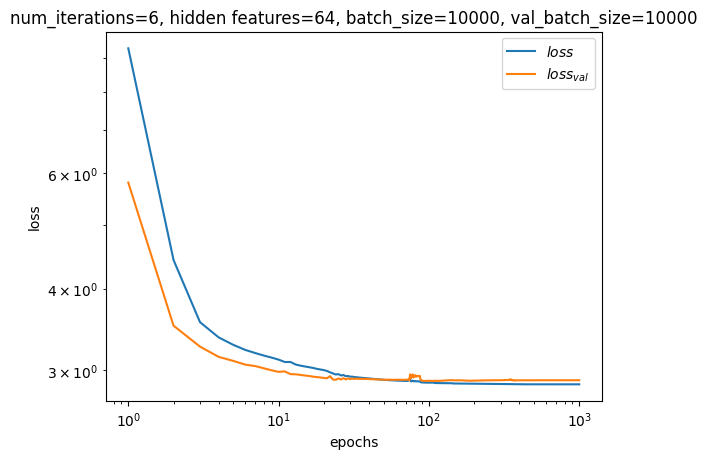

In [13]:
figloss=plt.figure()
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.title('num_iterations={}, hidden features={}, batch_size={}, val_batch_size={}'.format(6,64,batch_size,val_batch_size))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison_model1.png',dpi=190)

We now report an example of application of the flow: after sending our data into a normal distribution we can use the flow to generate new data, which will have the same distribution of the original data. This is the sampling procedure. The comparison between the original data and the generated data are an indication of how much the model was able to learn in the training. <br>
Therefore, in the `quantile_variation.ipynb` file we will focus on the sampled data after applying two different preprocessing transformations. <br><br>
In order to compare the new data with the original ones we must apply the preprocessing transformation in reverse, so we use the `backward` method. The figure below shows the two distributions compared.




In [15]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)
flow.load_state_dict(torch.load('modelli/epoch=999modello-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth'))
flow.eval()

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=64, out_features=64, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=8, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
             

In [16]:
sample_batch_size = 10000

sample = np.zeros(x.shape)

for t in range(0,len(sample), sample_batch_size):
  sample[t:t+sample_batch_size] = flow.sample(len(sample[t:t+sample_batch_size])).cpu().detach().numpy()

sample = x_preprocessor.backward(sample)

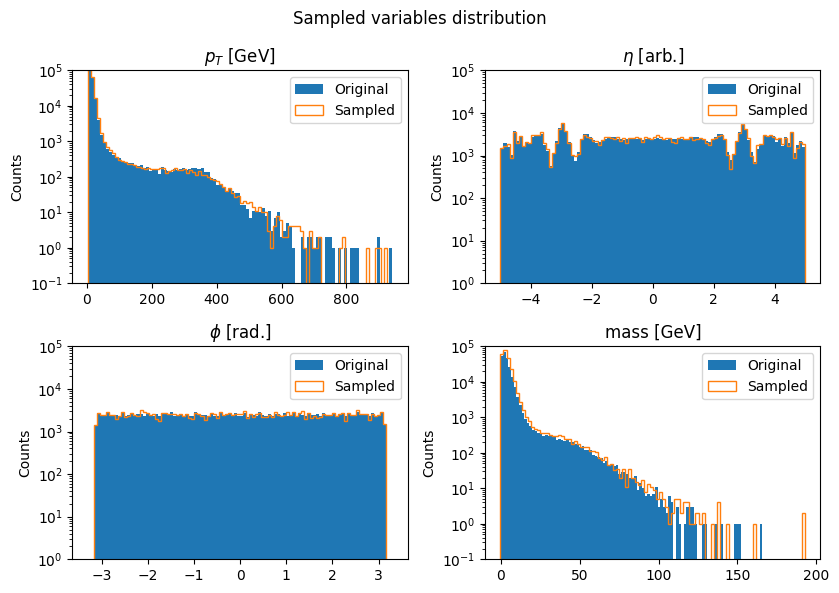

In [17]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1e-1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample.pdf',dpi=190)

To achieve lossy compression we created the `Compressor` class, it has two methods: one for compression and one for decompression. <br>The idea we want to implement is described by the following lines:
```
training
gaus = flow(data)
unif = erf(gaus)
unif' = unif * 2**N
unif'' = int(unif')
comp = unif''/2**N
gaus' = erfinv(comp)
data' = flow^-1(gaus') ==? data
```
Through the flow that we have learned we bring the original data into gaussian distributions, subsequently we can obtain uniform distributions using the `erf` function. Compression consists of casting as integer after rescaling the unit interval of the uniform distribution by a factor of `2**N`, where `N` is the number of compression bits used. We can now get the decompressed data using the `decompress` method.<br>
To make sure that the `erfinv` function does not return infinite numbers we use Scikit-learn's `MaxAbsScaler` in the `compress` method, rescaling everything to $3\sigma$. In the `decompress` method we apply the inverse transformation.





In [18]:
compression_batch_size = 10000

x_compressed= np.zeros(x.shape)
x_decompressed= np.zeros(x.shape)
gaus= np.zeros(x.shape)
unif= np.zeros(x.shape)
gaus_post = np.zeros(x.shape)

for t in range(0,len(xt), compression_batch_size):
  x_compressor = Compressor(flow=flow, N=13, limit=3)
  x_compressed[t:t+compression_batch_size], gaus[t:t+compression_batch_size], unif[t:t+compression_batch_size] = x_compressor.compress(xt[t:t+compression_batch_size])
  x_decompressed[t:t+compression_batch_size], gaus_post[t:t+compression_batch_size] = x_compressor.decompress(x_compressed[t:t+compression_batch_size])

x_compressed = x_compressed.astype(int)
x_decompressed = x_preprocessor.backward(x_decompressed)

We now present the plots of the Gaussian distributions returned by the flow,when it acts on the data. In the off-diagonal elements, the distributions are reported as a function of the others, via `scatter plot`.<br>
In addition, tests on the normality of the Gaussians are also performed, using [`scipy.stats.normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html).

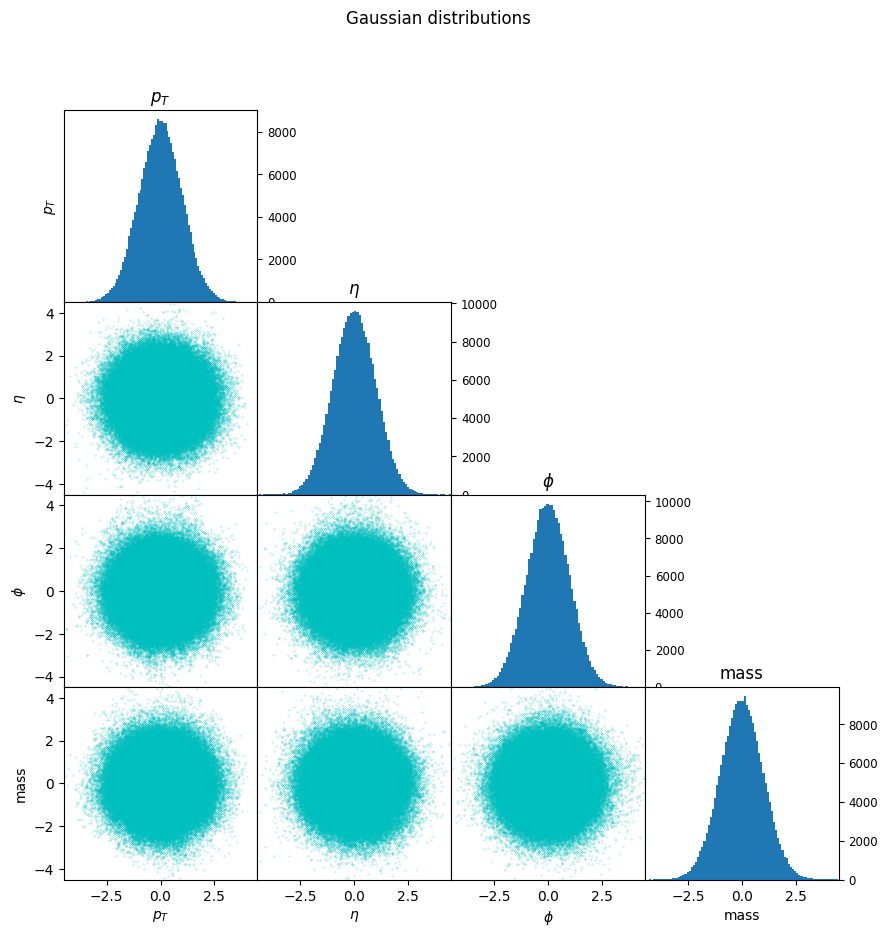

In [20]:
figgaus, axs = plt.subplots(4,4,figsize=(10,10))
figgaus.suptitle('Gaussian distributions')
figgaus.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus[:,f], bins=n_bins)
        axs[f,f].yaxis.tick_right()
        axs[h,f].set_xlim(-4.5,4.5)
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus[:,f],gaus[:,h],s=0.025,c='c')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus.savefig('figures/Gaussian_plot.png',dpi=190)

As we can read from the scipy documentation: $statistic = s^2+k^2$, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest. As reported [here](https://www.sciencedirect.com/topics/neuroscience/kurtosis), measures of kurtosis and skew are used to determine if indicators met normality assumptions. Both skew and kurtosis can be analyzed through descriptive statistics. Acceptable values of skewness fall between $\pm$ 3, and kurtosis is appropriate from a range of $\pm$ 10. All our results comply with the test.<br> <br>
The `pvalue` gives us information about the null hypothesis test, i.e. that our data is distributed as a $\mathcal{N}(0,1)$. The null hypothesis $H_0$ is rejected if the p-value is less than or equal to a predefined threshold value $α$, the significance level, which, in our case, is set at $\alpha = 0.05$. Looking at results obtained, we can state that $\eta$ is not distributed as a normal, while, for the other distributions, the test does not reject the null hypothesis.

### Ricorda di controllare il valore del pvalue

In [21]:
statistic, pvalue = stats.normaltest(gaus, axis=0)
print('Statistic = {}, pvalue = {}'.format(statistic,pvalue))

Statistic = [  3.08631982   0.33631444 119.4899826   67.70002547], pvalue = [2.13704745e-01 8.45220938e-01 1.13000394e-26 1.99125214e-15]


As done for the gaussian distributions, the uniform distributions obtained from the `erf` function are now also shown.


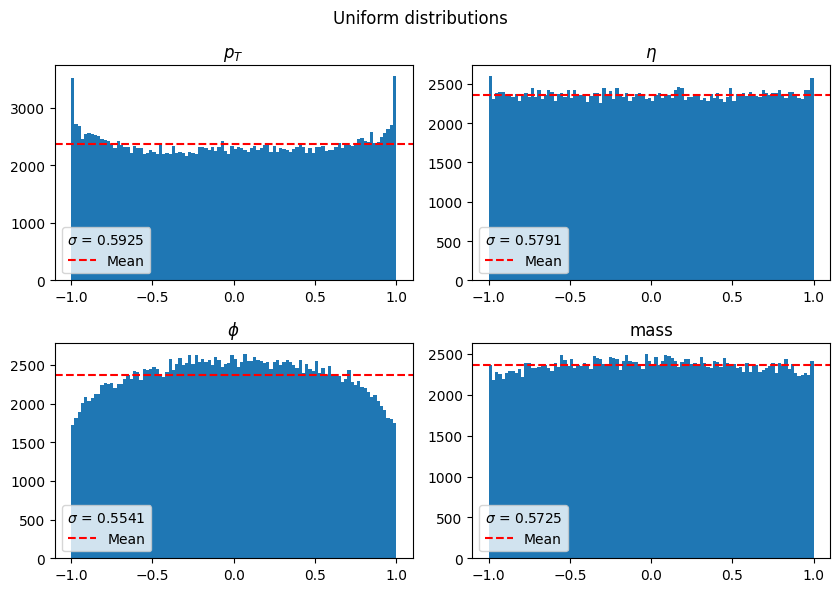

In [22]:
figunif,axs = plt.subplots(2, 2,figsize=(8.5,6))
figunif.suptitle('Uniform distributions')
n_bins = 100
mean=len(x)/n_bins

axs[0, 0].hist(unif[:,0],bins=n_bins)
axs[0, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{}'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,0])),loc='lower left')

axs[0, 1].hist(unif[:,1],bins=n_bins)
axs[0, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 1].set_title('{}'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,1])),loc='lower left')

axs[1, 0].hist(unif[:,2],bins=n_bins)
axs[1, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 0].set_title('{}'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,2])),loc='lower left')

axs[1, 1].hist(unif[:,3],bins=n_bins)
axs[1, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 1].set_title('{}'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,3])),loc='lower left')

figunif.tight_layout()
plt.show()
figunif.savefig('figures/Uniform_plot.pdf',dpi=190)

As done for the gaussian distributions obtained from the flow, the same `normaltest` was now repeated also for the gaussian distributions obtained from `erfinv`, those after compression.



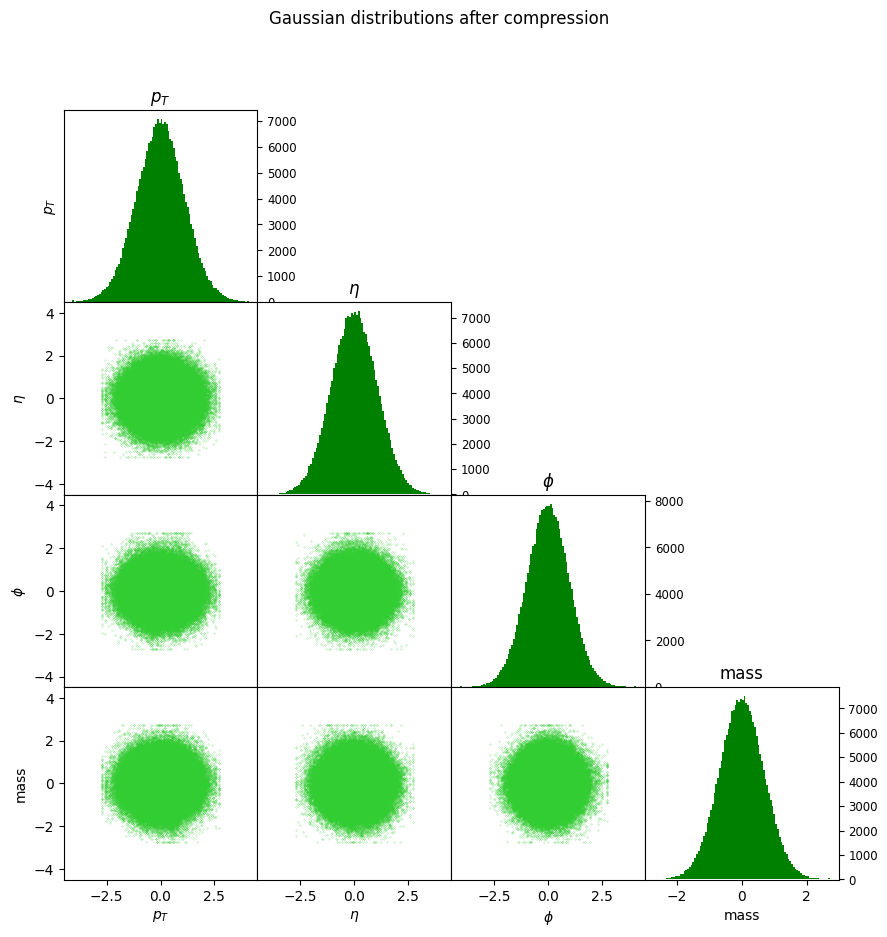

In [23]:
figgaus_post, axs = plt.subplots(4,4,figsize=(10,10))
figgaus_post.suptitle('Gaussian distributions after compression')
figgaus_post.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus_post.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus_post[:,f], bins=n_bins, facecolor='g')
        axs[f,f].yaxis.tick_right()
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus_post[:,f],gaus_post[:,h],s=0.025,c='limegreen')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus_post.savefig('figures/Gaussian_post_plot.png',dpi=190)

In [24]:
statistic_post, pvalue_post = stats.normaltest(gaus_post, axis=0)
print('Statistic post = {}, pvalue post = {}'.format(statistic_post,pvalue_post))

Statistic post = [ 64.66443408  18.73660489 267.10751082  93.3961324 ], pvalue post = [9.08440634e-15 8.53882166e-05 9.96187271e-59 5.23947211e-21]


We now represent the original and decompressed data, in particular by plotting the ratio and distribution of the difference.

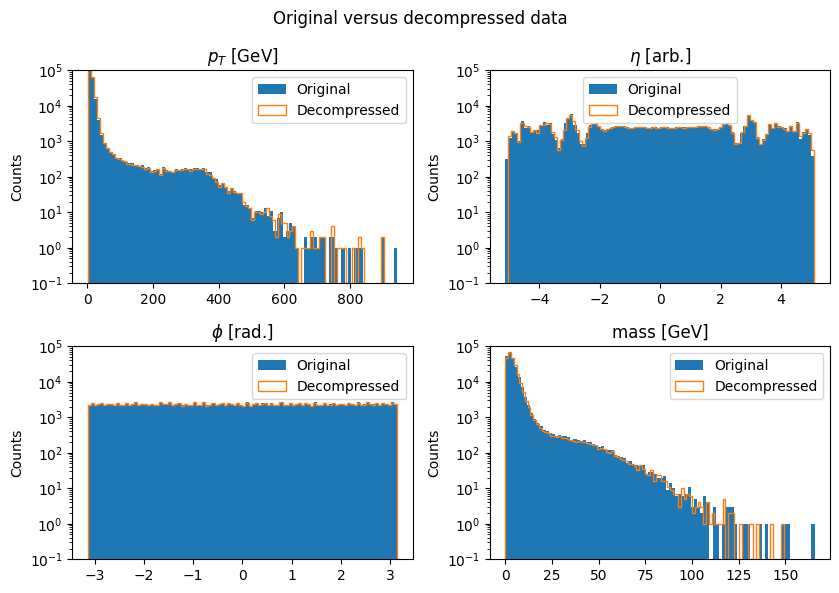

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Original versus decompressed data")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(x_decompressed[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")
axs[0, 0].set_ylim(1e-1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(x_decompressed[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")
axs[0, 1].set_ylim(1e-1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(x_decompressed[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(x_decompressed[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)


<ipython-input-73-ba88c70ddddd>:26: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-73-ba88c70ddddd>:26: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


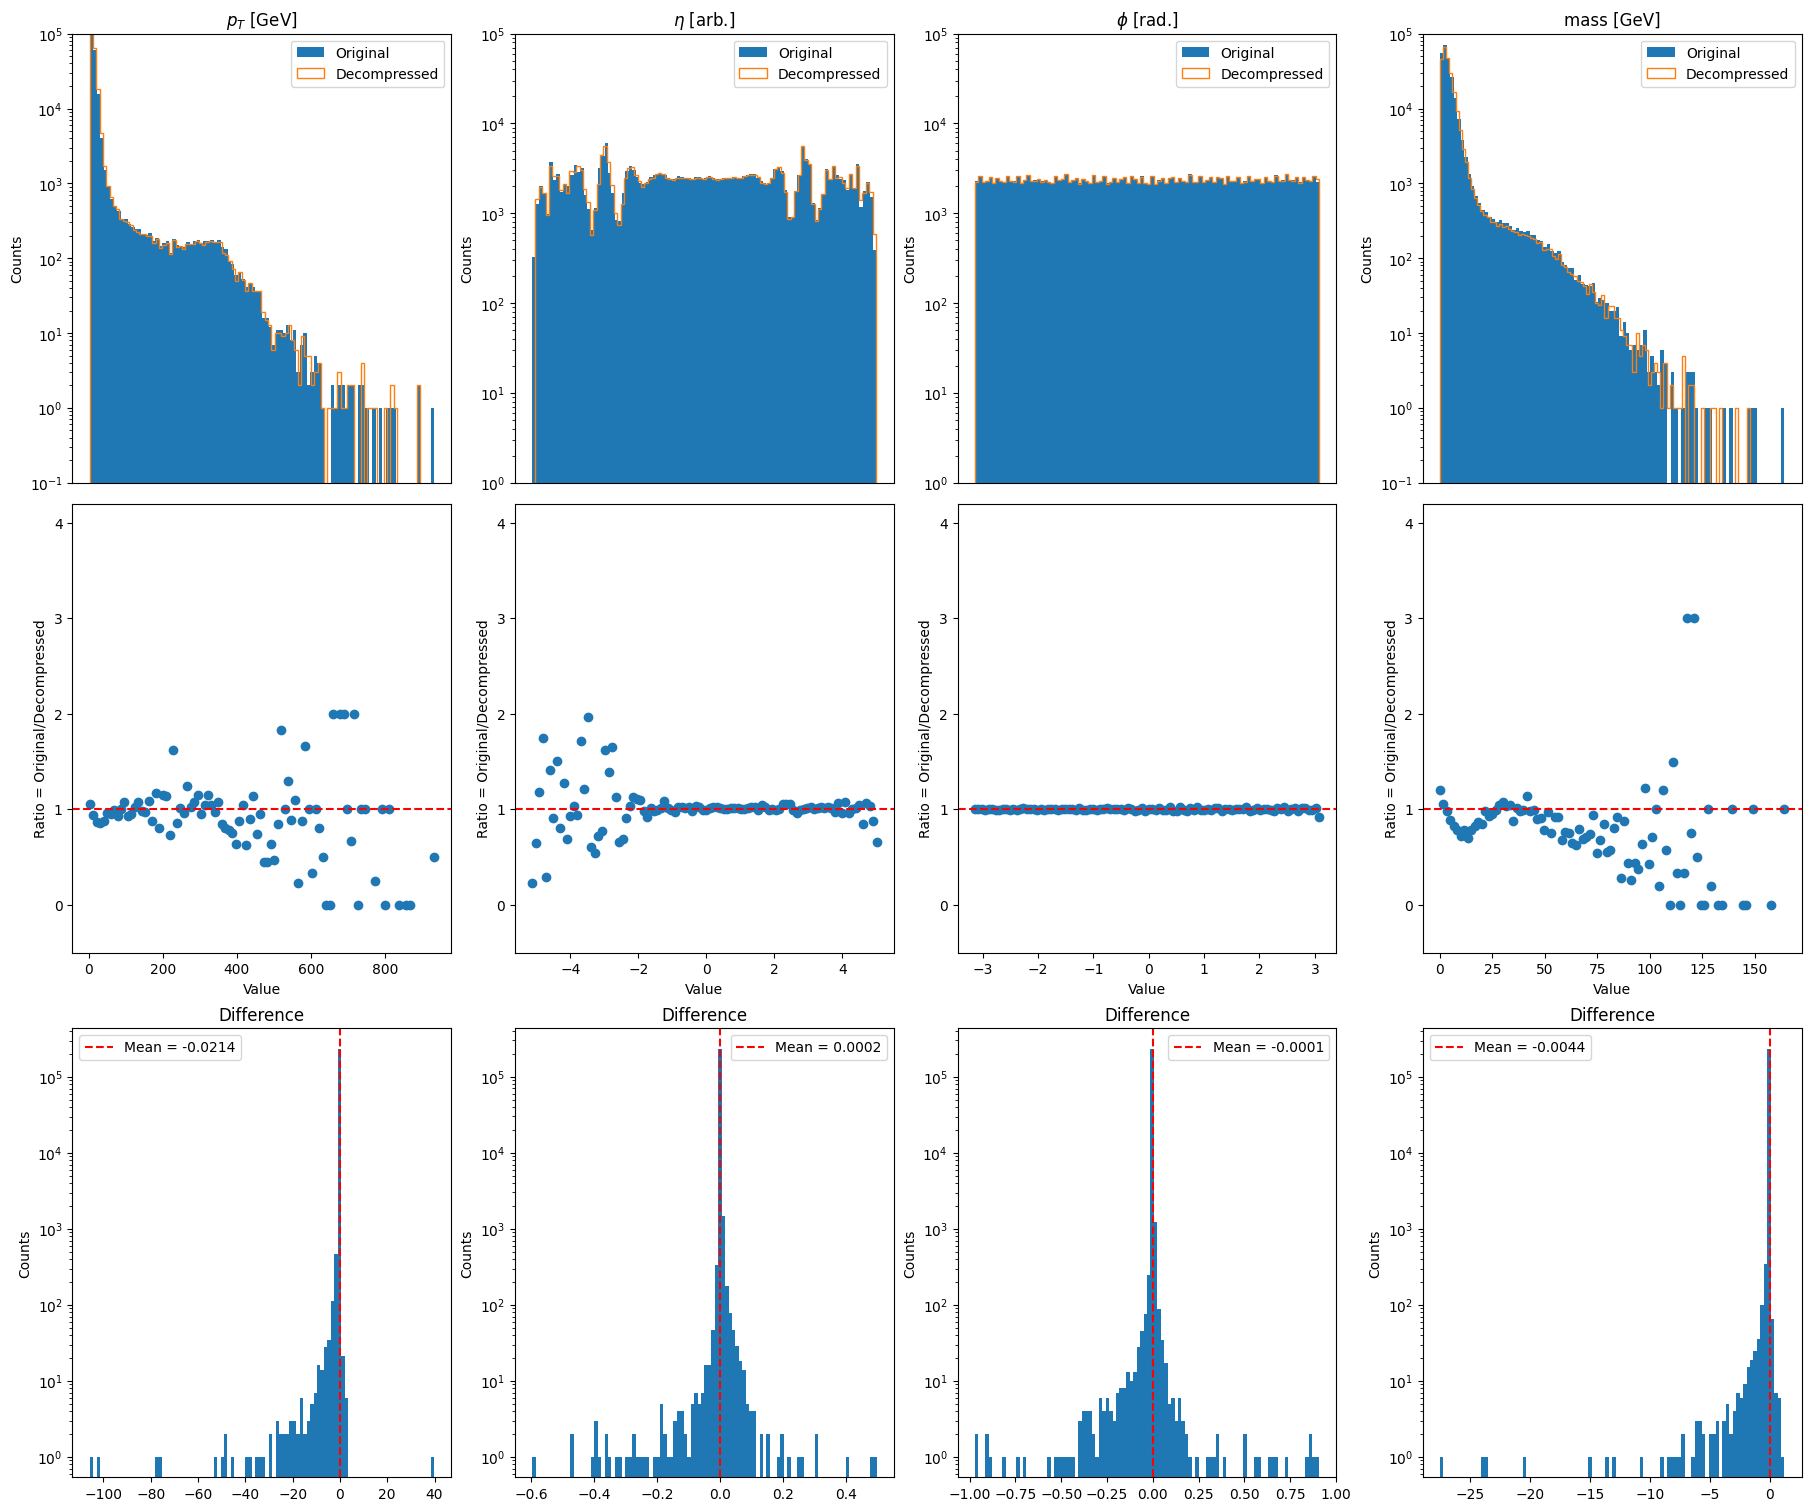

In [ ]:
difference = x_decompressed-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots")

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(x_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1e-1,10e4)
    axs[0, i].get_xaxis().set_ticks([])
    if i in [0,3]:
      axs[0, i].set_ylim(1e-1,10e4)
    if i in [1,2]:
      axs[0, i].set_ylim(1,10e4)


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio = Original/Decompressed")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4E}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference.pdf', dpi=190)

In [ ]:
response = np.divide(difference,x)

count = np.zeros(shape=(4))

for t in range(0,num_features):
  for y in range(0,len(response)):
    if np.isnan(response[y][t]) == True:
      count[t] +=1
    if np.isinf(response[y][t]) == True:
      count[t] +=1
      response[y][t] = 0
    if np.abs(response[y][t]) > 6e5:
      count[t] +=1
      response[y][t] = 0
print('Nans & Infs =', count)

mean_response = np.zeros(shape=(4))
for d in range(0,num_features):
  mean_response[d] = np.mean(response[:,d])

<ipython-input-125-0588edf8f12f>:1: RuntimeWarning: divide by zero encountered in divide
  response = np.divide(difference,x)


Nans & Infs = [ 0.  0.  0. 25.]


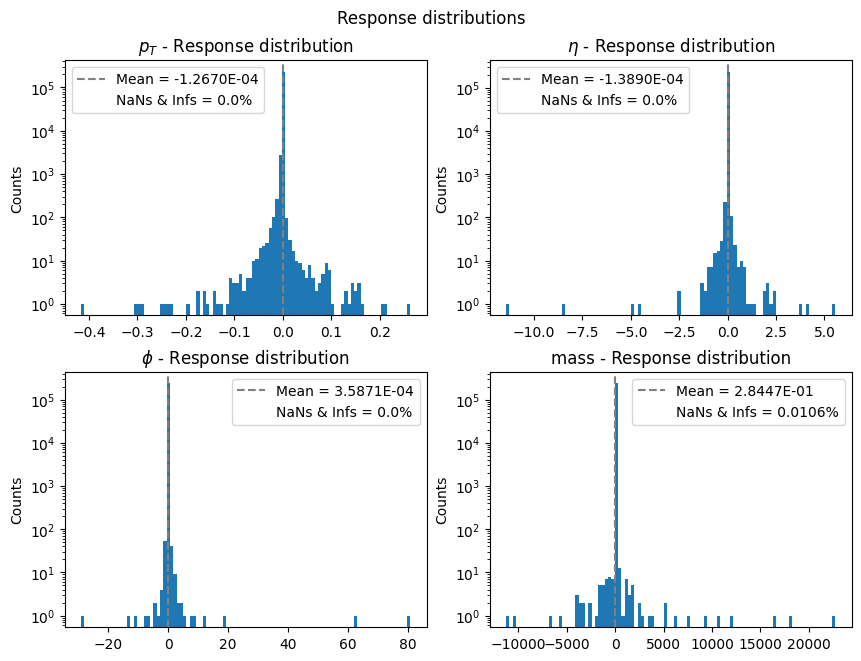

In [ ]:
fig_response, axs = plt.subplots(2, 2, figsize=(8.5, 6.5), layout='constrained')
fig_response.suptitle("Response distributions")

axs[0,0].set_title('{} - Response distribution'.format(labels_map[0]))
axs[0,0].hist(response[:,0], bins=n_bins, log=True)
axs[0,0].set_ylabel("Counts")
axs[0,0].axvline(x=mean_response[0], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[0]))
axs[0,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[0]*100/len(response)))
axs[0,0].legend()

axs[0,1].set_title('{} - Response distribution'.format(labels_map[1]))
axs[0,1].hist(response[:,1], bins=n_bins, log=True)
axs[0,1].set_ylabel("Counts")
axs[0,1].axvline(x=mean_response[1], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[1]))
axs[0,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[1]*100/len(response)))
axs[0,1].legend()

axs[1,0].set_title('{} - Response distribution'.format(labels_map[2]))
axs[1,0].hist(response[:,2], bins=n_bins, log=True)
axs[1,0].set_ylabel("Counts")
axs[1,0].axvline(x=mean_response[2], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[2]))
axs[1,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[2]*100/len(response)))
axs[1,0].legend()

axs[1,1].set_title('{} - Response distribution'.format(labels_map[3]))
axs[1,1].hist(response[:,3], bins=n_bins, log=True)
axs[1,1].set_ylabel("Counts")
axs[1,1].axvline(x=mean_response[3], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[3]))
axs[1,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[3]*100/len(response)))
axs[1,1].legend()

plt.show()
fig_response.savefig('figures/response.pdf', dpi=190)

To get the compression ratio, defined as:
$R = \frac{size(input~file)}{size(compressed~file)}$
, we create two new files with the used training data and the compressed one. In addition we also create a file for the decompressed data.<br>
The compression ratio is shown below.


In [ ]:
###.txt files

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio (.txt) =',size_input/size_compressed,'\n')

###.npz files
np.savez_compressed('input.npz', data=x)
np.savez_compressed('output.npz', data=x_decompressed)
np.savez_compressed('compressed.npz', data=x_compressed)

size_input_npz = stat('input.npz').st_size
print('Size of input file =',size_input_npz/(1024*1024),'MB')

size_output_npz = stat('output.npz').st_size
print('Size of output file =',size_output_npz/(1024*1024),'MB')

size_compressed_npz = stat('compressed.npz').st_size
print('Size of compressed file =',size_compressed_npz/(1024*1024),'MB')

print('Compression ratio (.npz) =',size_input_npz/size_compressed_npz)

Size of input file = 12.898502349853516 MB
Size of output file = 16.966094970703125 MB
Size of compressed file = 4.813551902770996 MB
Compression ratio (.txt) = 2.679622576091533 

Size of input file = 5.3632049560546875 MB
Size of output file = 6.964970588684082 MB
Size of compressed file = 2.3369903564453125 MB
Compression ratio (.npz) = 2.2949195923137697


We now study the compression ratio, the mean of the module of the residuals and the relative error as a function of `N`.


The definition of R is given above, instead for the other two we have:
$$
Residual = original - decompressed
$$
and
$$
Relative~error =\overline{\sqrt{\overline{\Big(\frac{original-decompressed}{std(original)}\Big)^2}}}
$$
where $std(x) = \sqrt{\frac{1}{N}\sum^{N}_{i=1}(x_i-\mu)^2}$ is the standard deviation of $x$ and $\mu$ is its mean.
Furthermore, the average under the square root is done column by column using `axis=0`.<br>
As expected, a decreasing behaviour is obtained for all functions.<br>
For the compression done before and for the one we will do now on the test data we have chosen to set `N=11`, with a compression ratio of approximately 3.


In [ ]:
RR_txt = []
RR_npz = []
residui = []
relative_error = []

for k in range(1,32):
    x_compressor_k = Compressor(flow=flow, N=k, limit=3)
    x_compressed_k, gaus_k, unif_ = x_compressor_k.compress(xt)
    x_decompressed_k, gaus_post_k = x_compressor_k.decompress(x_compressed_k)
    x_decompressed_k = x_preprocessor.backward(x_decompressed_k)

    with open('compressed_k.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(x_compressed_k[i, j]) for j in range(x_compressed_k.shape[1])) + "\n")

    size_compressed_k = stat('compressed_k.txt').st_size
    r_k = size_input/size_compressed_k
    RR_txt.append(r_k)

    np.savez_compressed('compressed_k.npz', data=x_compressed_k)

    size_compressed_k_npz = stat('compressed_k.npz').st_size
    r_k_npz = size_input_npz/size_compressed_k_npz
    RR_npz.append(r_k_npz)

    residui_k = np.mean(np.abs(x-x_decompressed_k))
    if k == 13:
      print('Mean of module of residual for N={}: {}'.format(k,residui_k))
    residui.append(residui_k)

    err_k =np.mean(np.sqrt(np.mean(((x - x_decompressed_k)/(x.std()))**2, axis=0)))
    if k == 13:
      print('Relative error for N={}: {}'.format(k,err_k))
    relative_error.append(err_k)

Mean of module of residual for N=13: 0.003226891555583077
Relative error for N=13: 0.002413600235863991


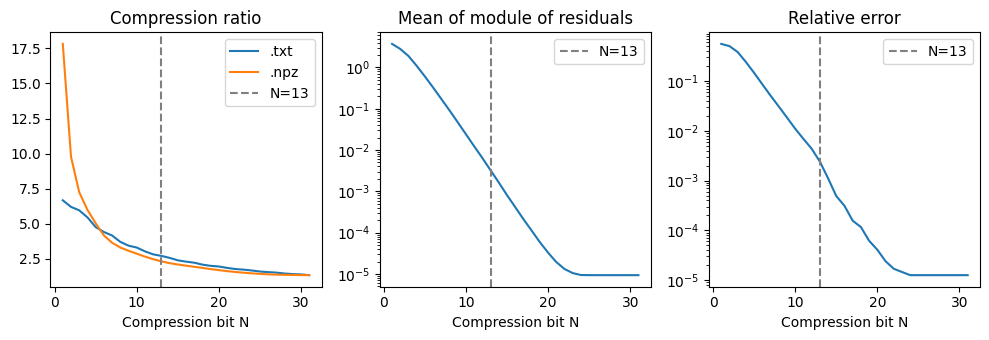

In [ ]:
fig, ax1 = plt.subplots(1,3,figsize=(10,3.5))

ax1[0].plot(range(1,k+1),RR_txt,label='.txt')
ax1[0].plot(range(1,k+1),RR_npz,label='.npz')
ax1[0].set_xlabel('Compression bit N')
ax1[0].set_title('Compression ratio')
ax1[0].tick_params(axis='y', which='minor', bottom=False)
ax1[0].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[0].legend()

ax1[1].plot(range(1,k+1),residui)
ax1[1].set_xlabel('Compression bit N')
ax1[1].set_title('Mean of module of residuals')
ax1[1].set_yscale('log')
ax1[1].tick_params(axis='y', which='minor', bottom=False)
ax1[1].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[1].legend()

ax1[2].plot(range(1,k+1),relative_error)
ax1[2].set_xlabel('Compression bit N')
ax1[2].set_title('Relative error')
ax1[2].set_yscale('log')
ax1[2].tick_params(axis='y', which='minor', bottom=False)
ax1[2].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[2].legend()

fig.tight_layout()
plt.show()
fig.savefig('figures/Compression_ratio.pdf',dpi=190)

We now perform compression on the test data, which is different from both the training and validation data. The procedure is similar to the one carried out previously: the data is preprocessed,the flow is used to compress this data and then it goes back, using `decompress` and `backward`. <br>
We always set `N=13` and the result is still approximately 3.

<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


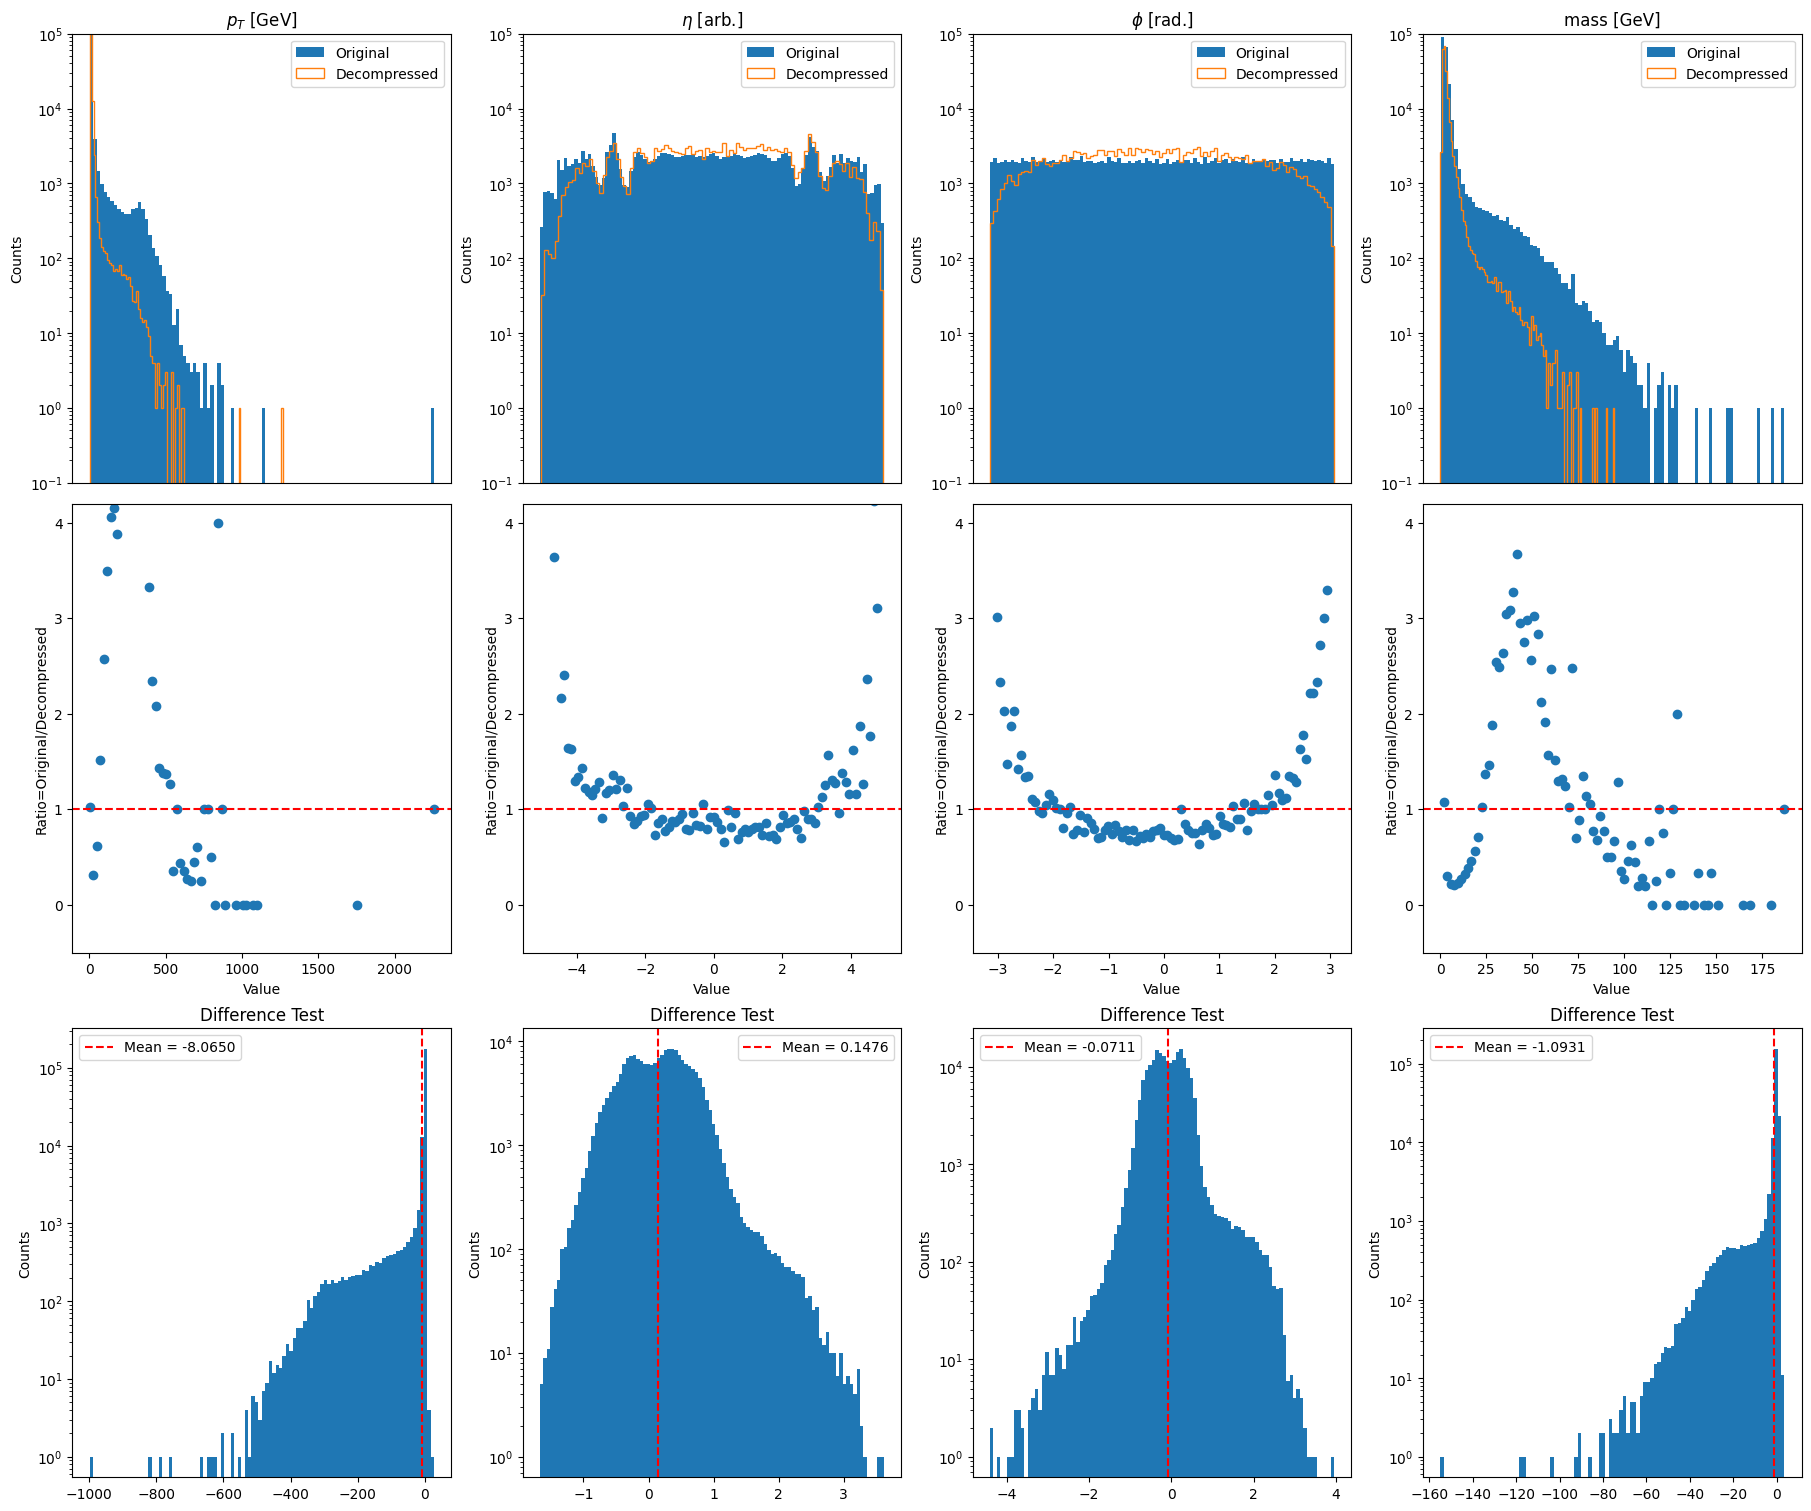

<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


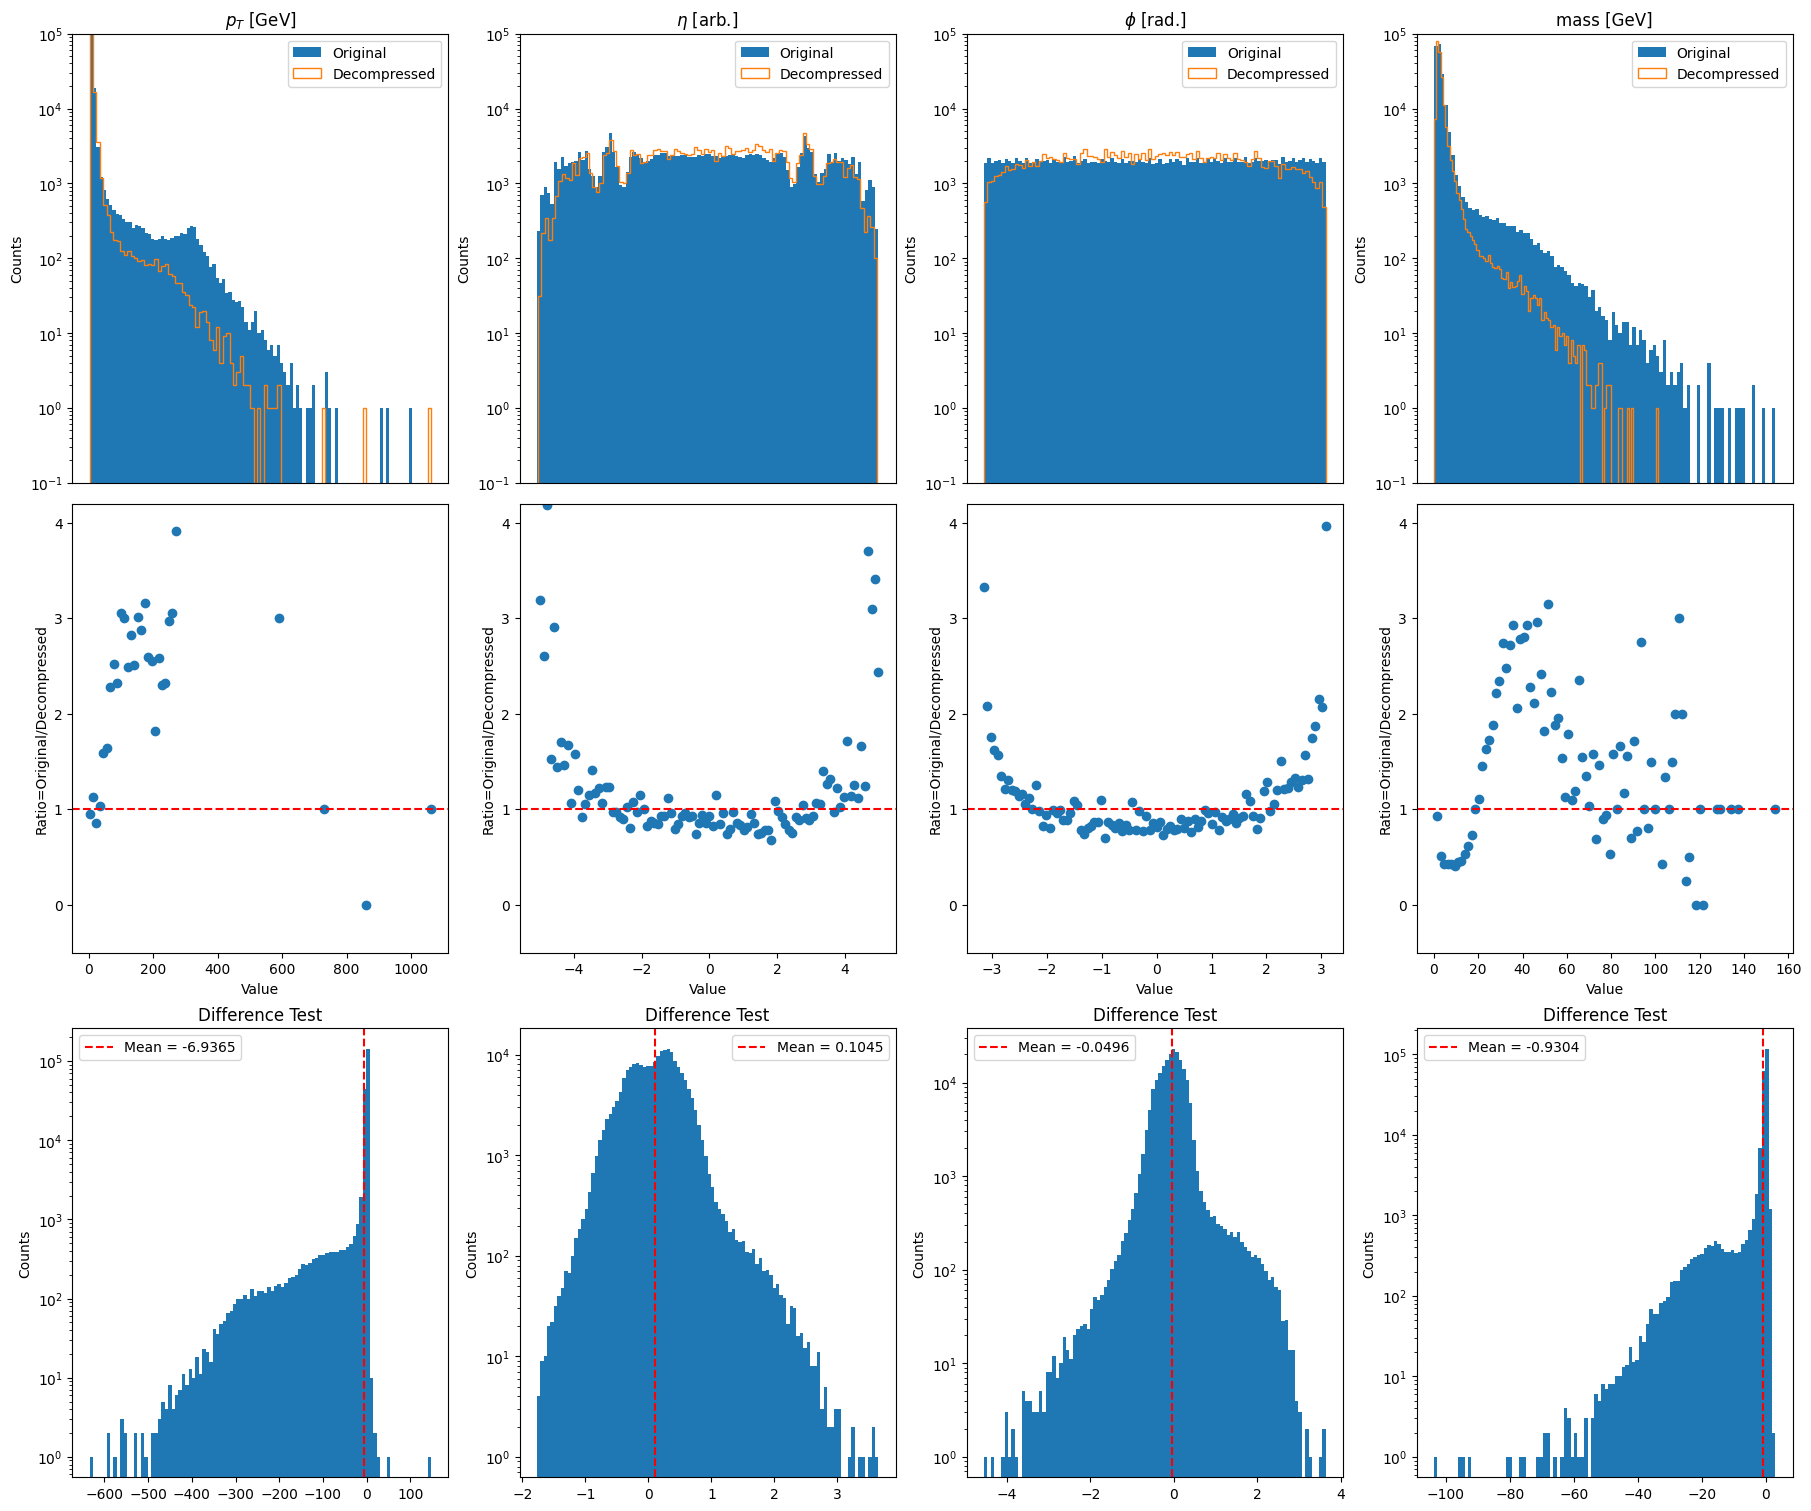

<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


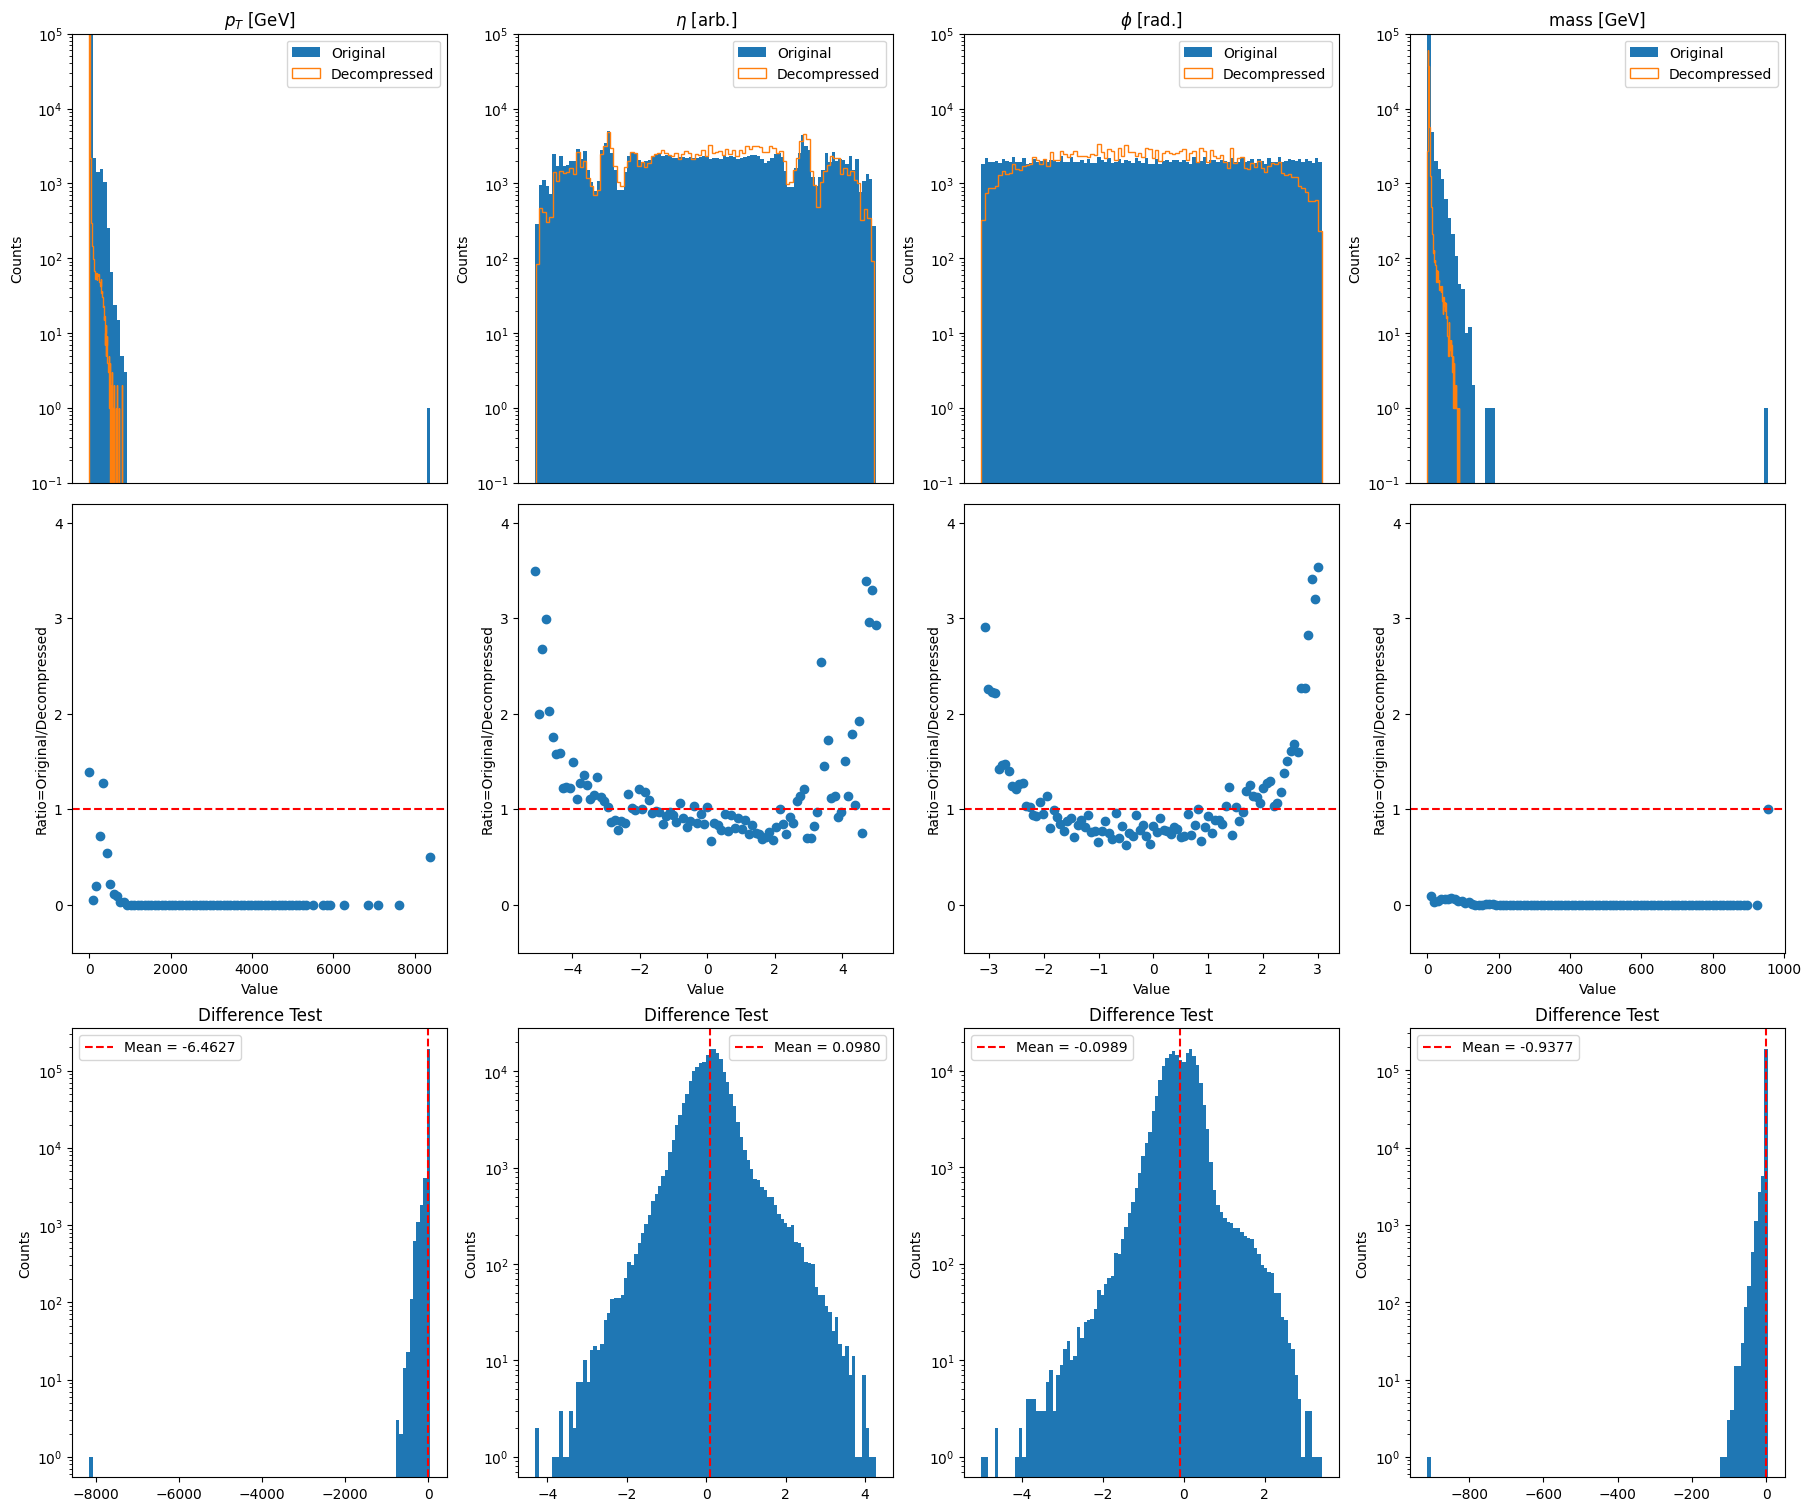

<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


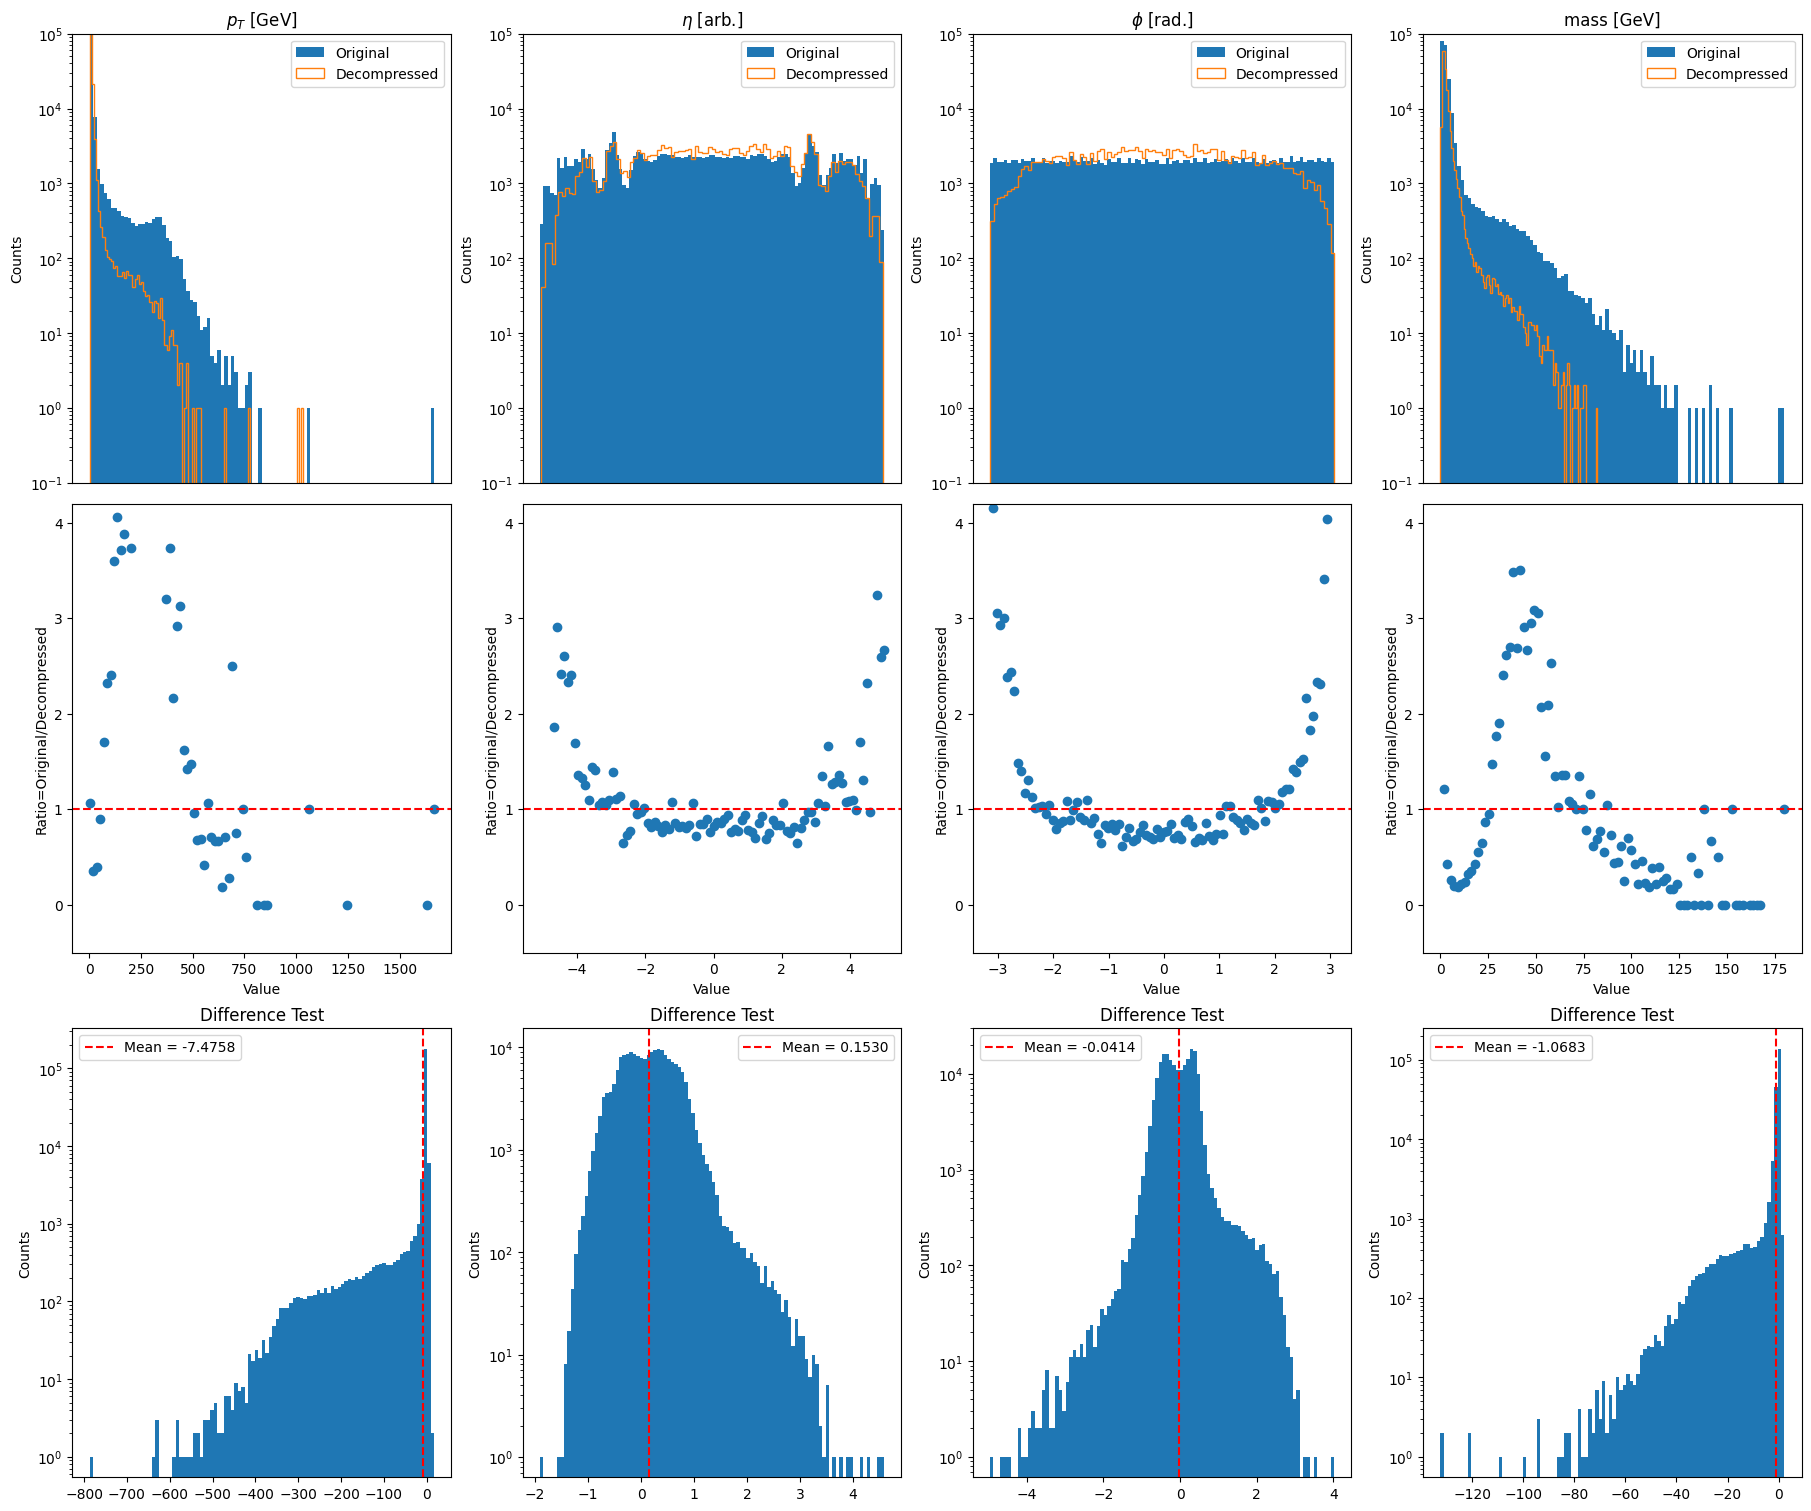

<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-25-bb1e6da2abd3>:67: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


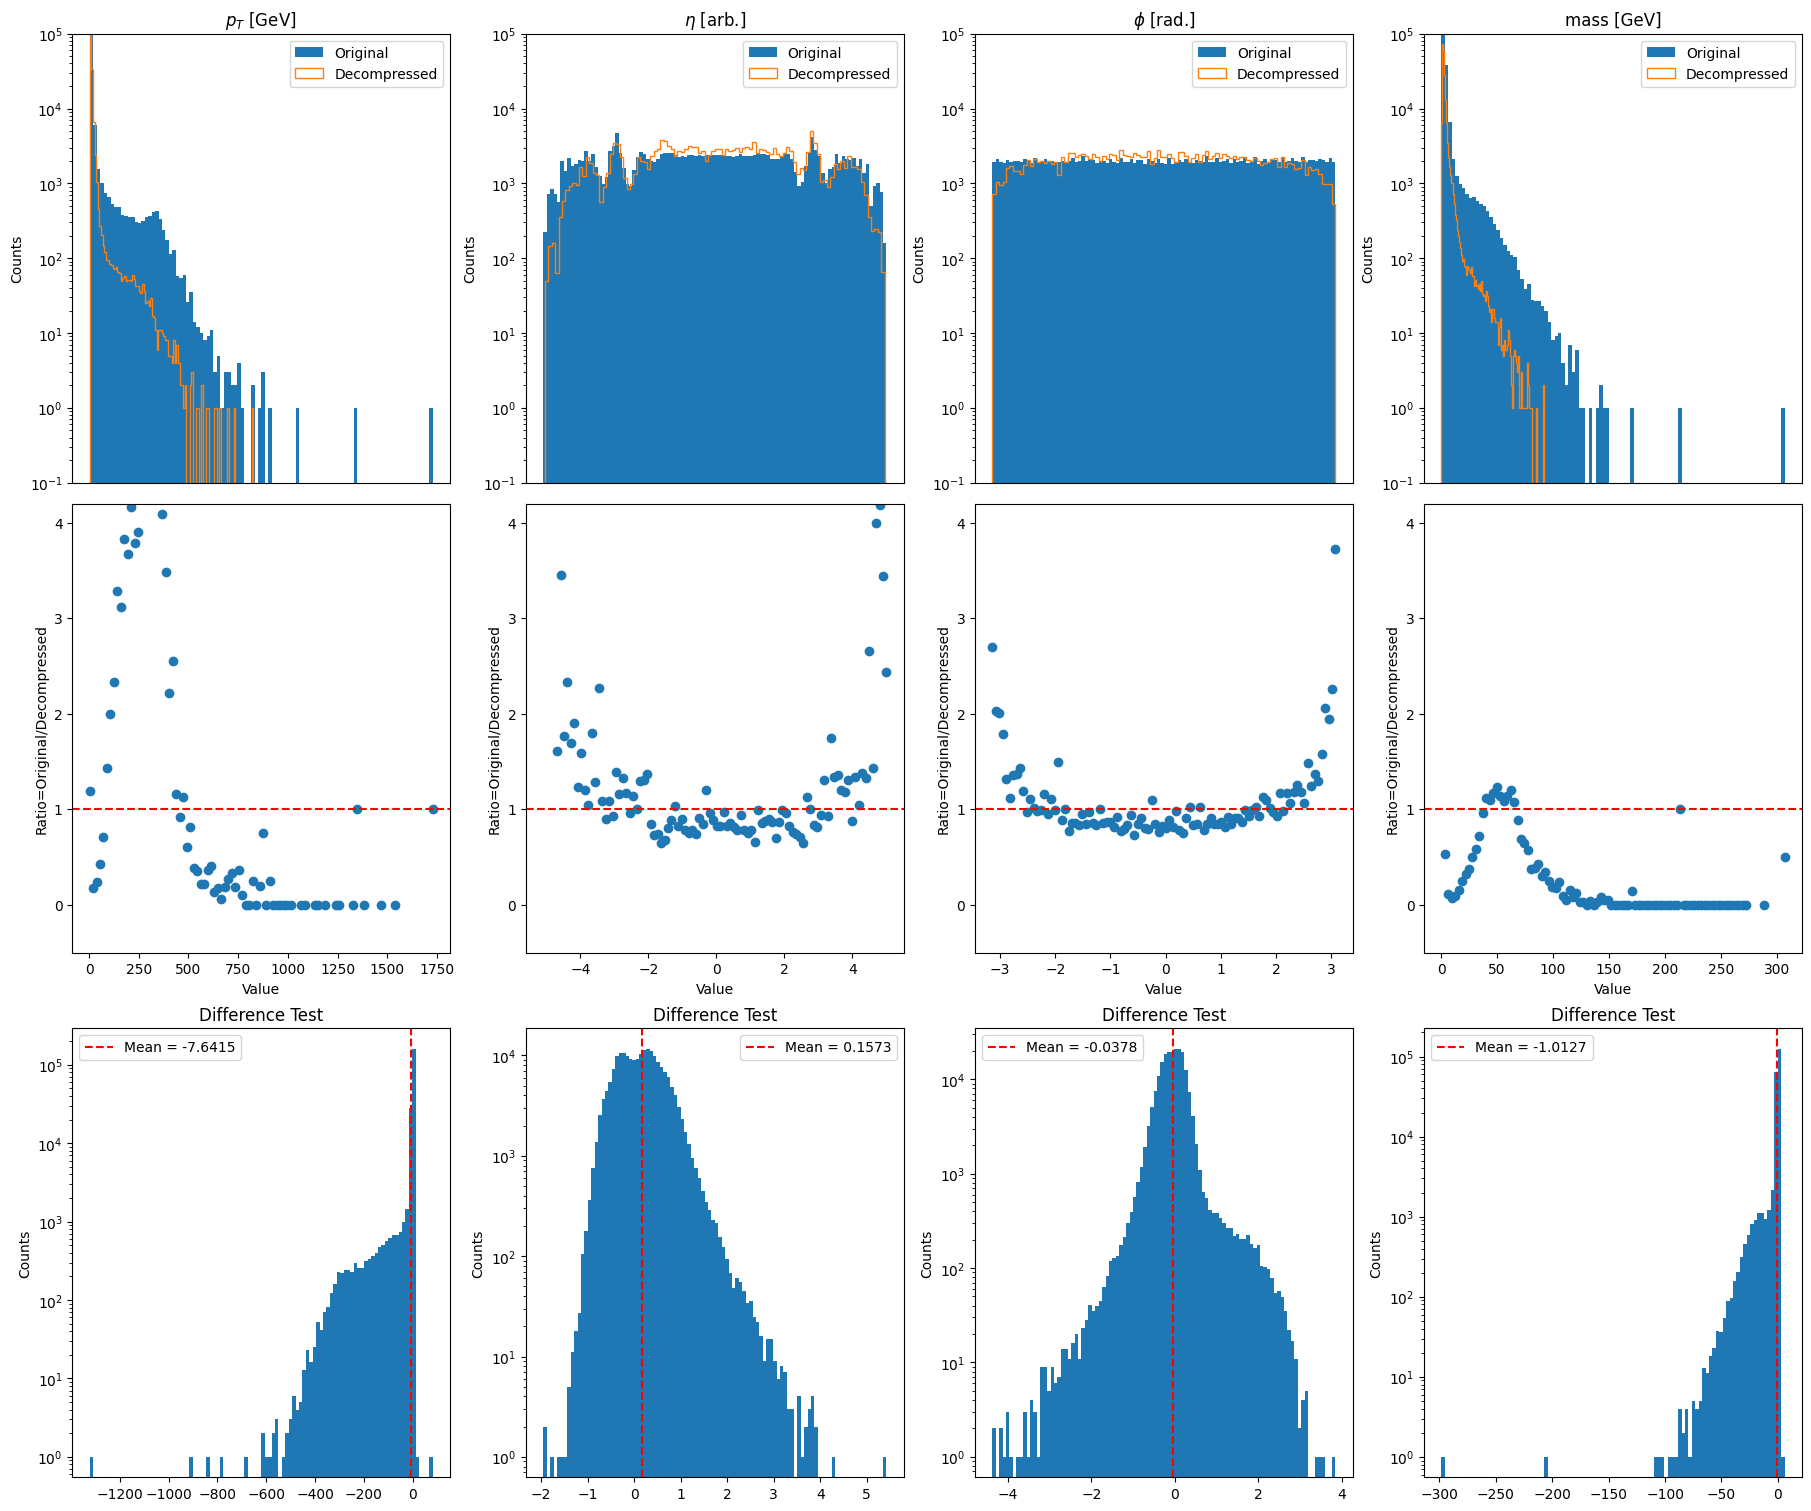

In [ ]:
###TESTING
test_batch_size = 200000
Rtest_txt = []
Rtest_npz = []
size_test_input = []
size_test_compressed = []
size_test_input_npz = []
size_test_compressed_npz = []

for w in range(0, 1000000, test_batch_size):

  xtest = np.copy(xtest_all[w:w+test_batch_size])

  compression_batch_size = 20000
  xtest_compressed= np.zeros(xtest.shape)
  xtest_decompressed= np.zeros(xtest.shape)
  gaus_test= np.zeros(xtest.shape)
  unif_test= np.zeros(xtest.shape)
  gaus_test_post = np.zeros(xtest.shape)

  xtest_preprocessor = Preprocessor(preprocessor_settings)
  xtest_preprocessed = xtest_preprocessor.forward(xtest)

  for t in range(0,len(xtest), compression_batch_size):
    xtest_compressor = Compressor(flow=flow, N=13, limit=3)
    xtest_compressed[t:t+compression_batch_size], gaus_test[t:t+compression_batch_size], unif_test[t:t+compression_batch_size] = xtest_compressor.compress(xtest_preprocessed[t:t+compression_batch_size])
    xtest_decompressed[t:t+compression_batch_size], gaus_test_post[t:t+compression_batch_size] = x_compressor.decompress(xtest_compressed[t:t+compression_batch_size])

  xtest_compressed = xtest_compressed.astype(int)
  xtest_decompressed = xtest_preprocessor.backward(xtest_decompressed)

  with open('test_input.txt', 'w') as test_input:
      for i in range(len(xtest)):
          test_input.write(' '.join(str(xtest[i, j]) for j in range(xtest.shape[1])) + "\n")
  with open('test_compressed.txt', 'w') as test_compressed:
          for i in range(len(xtest)):
              test_compressed.write(' '.join(str(xtest_compressed[i, j]) for j in range(xtest_compressed.shape[1])) + "\n")

  size_test_input.append((stat('test_input.txt').st_size)/(1024*1024))
  size_test_compressed.append((stat('test_compressed.txt').st_size)/(1024*1024))

  np.savez_compressed('test_input.npz', data=xtest)
  np.savez_compressed('test_compressed.npz', data=xtest_compressed)

  size_test_input_npz.append((stat('test_input.npz').st_size)/(1024*1024))
  size_test_compressed_npz.append((stat('test_compressed.npz').st_size)/(1024*1024))

  difference_test = xtest_decompressed-xtest

  fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
  fig.suptitle("Histogram and Ratio Plots for Test")
  n_bins = 100
  for i in range(4):
      y = []
      y.append(xtest[:, i])
      y.append(xtest_decompressed[:, i])

      ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
      ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
      axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
      axs[0, i].set_ylabel("Counts")
      axs[0, i].legend()
      axs[0, i].set_ylim(1e-1,10e4)
      axs[0, i].get_xaxis().set_ticks([])
      #axs[0][0].set_xlim(1,1500)

      axs[1, i].scatter(bins[:-1],ns/ns1)
      axs[1, i].axhline(y=1, color='r', linestyle='--')
      axs[1, i].set_xlabel("Value")
      axs[1, i].set_ylabel("Ratio=Original/Decompressed")
      axs[1, i].set_ylim(-0.5,4.2)


      axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
      axs[2, i].set_title("Difference Test")
      axs[2, i].set_ylabel("Counts")
      axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
      axs[2, i].legend()

  plt.show()
  fig_diff.savefig('figures/difference_test_{}.pdf'.format(w), dpi=190)

In [ ]:
print('Size input_test.txt [MB] =',size_test_input)
print('Size compressed_test.txt [MB] =',size_test_compressed)
rtest=np.divide(size_test_input,size_test_compressed)
print('Mean of R_test (.txt) = {:.4} +- {:.2}\n'.format(rtest.mean(),rtest.std()))

print('Size input_test.npz [MB] =',size_test_input_npz)
print('Size compressed_test.npz [MB] =',size_test_compressed_npz)
rtest_npz=np.divide(size_test_input_npz,size_test_compressed_npz)
print('Mean of R_test (.npz) = {:.4} +- {:.2}\n'.format(rtest_npz.mean(),rtest_npz.std()))

Size input_test.txt [MB] = [10.924564361572266, 10.923254013061523, 10.919051170349121, 10.9212064743042, 10.924205780029297]
Size compressed_test.txt [MB] = [4.064085960388184, 4.075299263000488, 4.073831558227539, 4.06300163269043, 4.066497802734375]
Mean of R_test (.txt) = 2.685 +- 0.0036

Size input_test.npz [MB] = [4.54837703704834, 4.547765731811523, 4.542427062988281, 4.544361114501953, 4.548833847045898]
Size compressed_test.npz [MB] = [1.9684410095214844, 1.9742822647094727, 1.9742364883422852, 1.9683055877685547, 1.971923828125]
Mean of R_test (.npz) = 2.306 +- 0.0035



In [ ]:
'''difference_test = xtest_decompressed-xtest

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots for Test")
n_bins = 100
for i in range(4):
    y = []
    y.append(xtest[:, i])
    y.append(xtest_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1e-1,10e4)
    axs[0, i].get_xaxis().set_ticks([])
    #axs[0][0].set_xlim(1,1500)

    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio=Original/Decompressed")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference Test")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference_test.pdf', dpi=190)'''

'difference_test = xtest_decompressed-xtest\n\nfig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout=\'constrained\')\nfig.suptitle("Histogram and Ratio Plots for Test")\nn_bins = 100\nfor i in range(4):\n    y = []\n    y.append(xtest[:, i])\n    y.append(xtest_decompressed[:, i])\n\n    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label=\'Original\', log=True)\n    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label=\'Decompressed\', histtype=\'step\')\n    axs[0, i].set_title(\'{} [{}]\'.format(labels_map[i],unit_measure[i]))\n    axs[0, i].set_ylabel("Counts")\n    axs[0, i].legend()\n    axs[0, i].set_ylim(1e-1,10e4)\n    axs[0, i].get_xaxis().set_ticks([])\n    #axs[0][0].set_xlim(1,1500)\n\n    axs[1, i].scatter(bins[:-1],ns/ns1)\n    axs[1, i].axhline(y=1, color=\'r\', linestyle=\'--\')\n    axs[1, i].set_xlabel("Value")\n    axs[1, i].set_ylabel("Ratio=Original/Decompressed")\n    axs[1, i].set_ylim(-0.5,4.2)\n\n\n    axs[2, i].hist(difference_test[:, i